<a href="https://colab.research.google.com/github/ZhengtingHe/DarkSHINE_GAN/blob/main/LOGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
#@title Choose type { run: "auto" }

particle_options = {
    "Inclusive": "/content/drive/MyDrive/Data/dp_ana_Inclusive.hdf5",
    "GMM_ECAL": "/content/drive/MyDrive/Data/dp_ana_GMM_ECAL.hdf5",
    "GMM_Target": "/content/drive/MyDrive/Data/dp_ana_GMM_Target.hdf5",
    "PN_ECAL": "/content/drive/MyDrive/Data/dp_ana_PN_ECAL.hdf5",
    "PN_Target": "/content/drive/MyDrive/Data/dp_ana_PN_Target.hdf5",

    "Inclusive_4e6": "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/Inclusive_ana_4e6.tfrecord",
    "GMM_ECAL_8e5": "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/GMM_ECAL_ana_8e5.hdf5",
    "GMM_Target_8e5": "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/GMM_Target_ana_8e5.hdf5",
    "PN_ECAL_4e5": "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/PN_ECAL_ana_4e5.hdf5",
    "PN_Target_4e5": "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/PN_Target_ana_4e5.hdf5",

    "Inclusive_cut_7GeV": "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/Inclusive_ana_4e6_cut_at_7GeV.hdf5",
    'Inclusive_larger_than_7GeV' :'/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/Inclusive_ana_4e6_cut_larger_then_7GeV.tfrecord'
}
particle_type = "PN_ECAL_4e5" #@param ['Inclusive', 'GMM_ECAL', 'GMM_Target', 'PN_ECAL', 'PN_Target', 'Inclusive_4e6', 'GMM_ECAL_8e5', 'GMM_Target_8e5', 'PN_ECAL_4e5', 'PN_Target_4e5', 'Inclusive_cut_7GeV', 'Inclusive_larger_than_7GeV']
particle_label = {particle_type : particle_options[particle_type]}
particle_label

{'PN_ECAL_4e5': '/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/PN_ECAL_ana_4e5.hdf5'}

In [78]:
from google.colab import drive
drive.mount("/content/drive")
Model_to_load = None
d_model_to_load = None
path = "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/Models/"

#d_model_to_load = path+'2021-07-14_21:47:32LOGANdiscriminator_PN_Target_4e5.hdf5'
#Model_to_load = path+'2021-07-14_21:47:32LOGANgenerator_PN_Target_4e5.hdf5'
aux_model = None
hdf5_dataset = (list(particle_label.values())[0][-4:] == 'hdf5')
tfrecord_dataset = (list(particle_label.values())[0][-8:] == 'tfrecord')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [79]:
if tfrecord_dataset:
    print("Using tfrecords format")
if hdf5_dataset:
    print('Using hdf5 format')

Using hdf5 format


# Hyper parameters

In [80]:
#fake_loss_function = 'binary_crossentropy'
fake_loss_function = 'mse'

energy_cut = 1e-3 #MeV
#energy_cut = 0

nb_epochs = 10
batch_size = 600
latent_size = 1024

TRAIN_BUF=34025
BATCH_SIZE=batch_size
TEST_BUF=1024
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)
generator_extra_step = 3
discriminator_extra_steps = 1

#disc_lr = 2e-6

#disc_lr = 2e-4
#disc_lr = 1e-7
disc_lr = 1e-5
clas_lr = disc_lr
#disc_lr = 5e-4

#gen_lr = 2e-5
gen_lr = 2e-4
#gen_lr = 1e-6
#gen_lr = 1e-4
#gen_lr = 5e-4

adam_beta_1 = 0.5

lambda_E = 1e2

E_factor = 0

lambda_sparsity = 10
ELU_alpha = 1e-5

embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

g_pfx = 'params_generator_epoch_'
d_pfx = 'params_discriminator_epoch_'

# Hyper-parameters form

In [117]:
#@title Hyper-parameters form { run: "auto", vertical-output: true, display-mode: "form" }
disc_lr =  1e-3#@param {type:"number"}
disc_opt = "Adam" #@param ["Adam", "Nadam"]
gen_lr = 1e-3 #@param {type:"number"}
gen_opt = "Nadam" #@param ["Adam", "Nadam"]
energy_cut = 1e-3 #@param {type:"number"}
generator_extra_step =   1#@param {type:"integer"}
discriminator_extra_steps =  1#@param {type:"integer"}
batch_size = 500 #@param {type:"slider", min:100, max:1000, step:100}
final_layer_activation = "softplus" #@param ["relu", "softplus"]
z_alpha =  0.9#@param {type:"number"}
z_beta =  0.1 #@param {type:"number"}
g_network_type = "DownSampling" #@param ["UpSampling", "DownSampling"]
use_latent_optimization = True #@param ["True", "False"] {type:"raw"}
decay_steps = 1000 #@param {type:"slider", min:100, max:2000, step:100}
decay_rate = 0.9 #@param {type:"number"}
end_learning_rate =  1e-6#@param {type:"number"}

# Configure

## Import

In [107]:
from tensorflow import keras
import keras.backend as K
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Nadam
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
from datetime import datetime
from tensorflow.keras.layers import (Input, Dense, Reshape, Conv2D, LeakyReLU,
                          BatchNormalization, LocallyConnected2D, 
                          Activation, ZeroPadding2D, Lambda, Flatten,
                          Embedding, ELU, Dropout, UpSampling2D, Cropping2D, LayerNormalization, 
                          MultiHeadAttention
                          )
from tensorflow.keras.layers import concatenate
import time
import h5py
from IPython import display
##MBD import
#from keras.engine import InputSpec, Layer
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers, regularizers, constraints, activations
from tensorflow.keras.layers import Lambda, ZeroPadding2D, LocallyConnected2D

#from sklearn.preprocessing import LabelEncoder
#from sklearn.utils import shuffle
import pandas as pd
from tqdm.autonotebook import tqdm

!pip install deepdish
import deepdish as dd

class Dense3D(Layer):

    """
    A 3D, trainable, dense tensor product layer
    """

    def __init__(self, first_dim,
                 last_dim,
                 activation=None,
                 use_bias=True,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(Dense3D, self).__init__(**kwargs)
        self.first_dim = first_dim
        self.last_dim = last_dim
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

    def build(self, input_shape):
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]

        self.kernel = self.add_weight(
            shape=(self.first_dim, input_dim, self.last_dim),
            initializer=self.kernel_initializer,
            name='kernel',
            regularizer=self.kernel_regularizer,
            constraint=self.kernel_constraint,
            trainable=True,
        )
        if self.use_bias:
            self.bias = self.add_weight(
                shape=(self.first_dim, self.last_dim),
                initializer=self.bias_initializer,
                name='bias',
                regularizer=self.bias_regularizer,
                constraint=self.bias_constraint,
                trainable=True,
            )
        else:
            self.bias = None
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    def call(self, inputs, mask=None):
        out = tf.reshape(tf.matmul(inputs, self.kernel), (-1, self.first_dim, self.last_dim))
        if self.use_bias:
            out += self.bias
        return out

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.first_dim, self.last_dim)

    def get_config(self):
        config = {
            'first_dim': self.first_dim,
            'last_dim': self.last_dim,
            'activation': activations.serialize(self.activation),
            'use_bias': self.use_bias,
            'kernel_initializer': initializers.serialize(self.kernel_initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer),
            'kernel_constraint': constraints.serialize(self.kernel_constraint),
            'bias_constraint': constraints.serialize(self.bias_constraint)
        }
        base_config = super(Dense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

class MinibatchStdev(Layer):
    def __init__(self, **kwargs):
        super(MinibatchStdev, self).__init__(**kwargs)

    # calculate the mean standard deviation across each pixel coord
    def call(self, inputs):
        mean = K.mean(inputs, axis=0, keepdims=True)
        mean_sq_diff = K.mean(K.square(inputs - mean), axis=0, keepdims=True) + 1e-8
        mean_pix = K.mean(K.sqrt(mean_sq_diff), keepdims=True)
        shape = K.shape(inputs)
        output = K.tile(mean_pix, [shape[0], shape[1], shape[2], 1])
        return K.concatenate([inputs, output], axis=-1)

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 1
        return tuple(input_shape)

class MinibatchVariableStdev(Layer):
    def __init__(self, **kwargs):
        super(MinibatchVariableStdev, self).__init__(**kwargs)

    def call(self, inputs):
        mean = K.mean(inputs, axis=0, keepdims=True)
        mean_sq_diff = K.mean(K.square(inputs - mean), axis=0, keepdims=True) 
        mean_pix = K.mean(K.sqrt(mean_sq_diff), keepdims=True)
        shape = K.shape(inputs)
        mean_output = K.tile(mean, [shape[0], 1])
        output = K.tile(mean_pix, [shape[0], 1])

        return K.concatenate([inputs, mean_output, output], axis=-1)

    # define the output shape of the layer
    def compute_output_shape(self, input_shape):
        input_shape = list(input_shape)
        input_shape[-1] += 2
        return tuple(input_shape)


## Instance

In [83]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jul 21 12:13:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    40W / 250W |  15977MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Read HDF5 file

In [84]:
def read_file(particle, infile):
    #h5file = h5py.File(infile, 'r')
    h5file = dd.io.load(particle_label[particle])
    ECAL_centre = h5file['ECAL_centre']
    Energy = h5file["Energy"]
    sizes = ECAL_centre.shape
    print("There are {} events with {} x {} layout for {}".format(sizes[0], sizes[1], sizes[2],particle))
    y = [particle] * ECAL_centre.shape[0]

    return ECAL_centre, Energy, sizes, y

In [85]:
if hdf5_dataset:
    nb_classes = len(particle_label)
    print("There {} types of particles".format(nb_classes))
    ECAL_centre, Energy, sizes, y = [
    np.concatenate(t) for t in [
                                a for a in zip(*[read_file(p, f) for p, f in particle_label.items()])
                                ]
    ]
    #le = LabelEncoder()
    #y = le.fit_transform(y)
    #print(list(le.classes_))
    print(list(particle_label.keys())[0])
    #ECAL_centre, Energy, y = shuffle(ECAL_centre, Energy, y, random_state=0)
    sizes = ECAL_centre.shape
    sizes = np.shape(ECAL_centre)

    train_images = (ECAL_centre.reshape(sizes[0], 20, 20, 1).astype('float32'))/1000#The scale of eV should be enough 

    #train_images = train_images * (train_images>energy_cut)
    Energy = (Energy.reshape(sizes[0]).astype('float32'))/1000
    print("The shape of tranning data is",train_images.shape)

    train_dataset = (
        tf.data.Dataset.from_tensor_slices({
            'images' :train_images, 
            'energy' :Energy
            })
        .shuffle(train_images.shape[0], reshuffle_each_iteration=True)
        .batch(batch_size)
        #.prefetch(tf.data.AUTOTUNE)
        )

There 1 types of particles
There are 401201 events with 20 x 20 layout for PN_ECAL_4e5
PN_ECAL_4e5
The shape of tranning data is (401201, 20, 20, 1)


## Read tfrecord

In [86]:
def parse_tfr_element(element):
    data = {
        'images':tf.io.FixedLenFeature([], tf.string),
        'energy':tf.io.FixedLenFeature([], tf.float32),
        }

    content = tf.io.parse_single_example(element, data)
    raw_image = content['images']
    energy = content['energy']

    feature = tf.io.parse_tensor(raw_image, out_type=tf.float32)
    feature = tf.reshape(feature, shape=[20,20,1])/1000
    energy = tf.reshape(energy, shape=[1])/1000
    return {'images': feature, 
            'energy': energy
            }

def get_dataset_small(filename):
    #create the dataset
    dataset = tf.data.TFRecordDataset(filename)

    #pass every single feature through our mapping function
    dataset = dataset.map(parse_tfr_element,num_parallel_calls=tf.data.AUTOTUNE)

    return dataset

In [87]:
if tfrecord_dataset:
    tfrecord_file = list(particle_label.values())[0]
    train_dataset = get_dataset_small(tfrecord_file)
    test_dataset = get_dataset_small(tfrecord_file)
    sizes = []
    #sizes.append(test_dataset.reduce(np.int64(0), lambda x, _: x + 1).numpy())
    sizes.append(4000000)
    print(sizes)
    for sample in test_dataset.take(1):
        print(sample['images'].shape)
        for i in list(sample['images'].shape):
            sizes.append(i)
        print(sample['energy'].shape)
    print(sizes)
    train_dataset = train_dataset.shuffle(sizes[0], reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    #train_dataset = train_dataset.cache()

# Functions

## Plotting functions

In [88]:
from matplotlib.colors import LogNorm
def plot_2D_image(image, epoch,log=True):    
    fig, ax = plt.subplots(figsize=(5,5))
    if np.max(image)>0:
      energy = ax.imshow(
      image,norm = LogNorm(
          vmin=1e-3,
          vmax=6e3
          )
      )
    else :
      energy = ax.imshow(
      image
      )
    colorbar = fig.colorbar(energy);
    colorbar.set_label(r'Energy (MeV)')
    colorbar.ax.tick_params()
    xticks = range(20)
    yticks = range(20)


    #Plot real image
    if epoch == -2:
        title = 'Real'
    #Plot fake image
    elif epoch == -1:
        title = 'Counterfeit'
    else:
        title = '2D plot for epoch{:03d}'.format(epoch)
    ax.set_title(title)
    if epoch > -1:
        plt.savefig('2D_image_at_epoch_{:03d}.png'.format(epoch))
    plt.xticks(xticks)
    plt.yticks(yticks)
    plt.show()

def plot_3D_image(image, epoch):
    x_gird = np.arange(0, 20, 1)
    y_gird = np.arange(0, 20, 1)
    X_gird, Y_gird = np.meshgrid(x_gird, y_gird)    
    fig = plt.figure(figsize=(13, 7))
    ax = plt.axes(projection='3d')
    surf = ax.plot_surface(X_gird, Y_gird, image, rstride=1, cstride=1, cmap='coolwarm', edgecolor='none')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel(r'Energy (MeV)')
    if epoch == -2:
        title = 'Real'
    elif epoch == -1:
        title = 'Counterfeit'
    else:
        title = 'Surface plot for epoch{:04d}'.format(epoch)
    ax.set_title(title)
    fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the energy
    ax.view_init(60, 35)
    if epoch > -1:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

def plot_loss(loss, x_title='Epoch',fig_width=10,fig_height=10):
    fig=plt.figure(num=1,figsize=(fig_width,fig_height))

    epochs = np.arange(1, len(loss)+1)
    #"d_loss","d_cost", "gp", "g_loss", "g_cost","E_loss"
    d_loss = loss.d_loss.values
    d_cost = loss.d_cost.values
    gp = loss.gp.values
    g_loss = loss.g_loss.values
    g_cost = loss.g_cost.values
    E_loss = loss.E_loss.values


    ax1=fig.add_subplot(221)
    ax1.set_xlabel(x_title)
    ax1.set_ylabel('loss')
    ax1.plot(epochs, d_loss, color='blue', marker='o', label='Discriminator loss')
    ax1.plot(epochs, g_loss, color='red', marker='*',label='Generator loss')
    ax1.grid(axis='y')
    ax1.legend()

    ax2 = fig.add_subplot(222)
    ax2.set_xlabel(x_title)
    ax2.set_ylabel('loss')
    ax2.plot(epochs, d_cost, color='blue', marker='o', label='Discriminator cost')
    ax2.plot(epochs, g_cost, color='red', marker='*',label='Generator cost')
    ax2.grid(axis='y')
    ax2.legend()

    ax3 = fig.add_subplot(223)
    ax3.set_xlabel(x_title)
    ax3.set_ylabel('loss')
    ax3.plot(epochs, E_loss, color='green', marker='D',label='Energy loss')
    ax3.legend()
    ax3.grid(axis='y')
    ax3.set_yscale('log')

    ax4 = fig.add_subplot(224)
    ax4.set_xlabel(x_title)
    ax4.set_ylabel('loss')
    ax4.plot(epochs, gp, color='green', marker='D',label='Gradient Panelty')
    ax4.legend()
    ax4.grid(axis='y')

    plt.show()

## OPS functions

In [89]:
def single_layer_energy(x):
    shape = x.shape
    return K.reshape(K.sum(x, axis=list(range(1, len(shape)))), (-1, 1))


def single_layer_energy_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4

    return (shape[0], 1)


def calculate_energy(x):
    return Lambda(single_layer_energy, single_layer_energy_output_shape, name='Output_energy')(x)

if final_layer_activation == "relu":
    energy_cut = 0
    
def single_layer_sparsity(x):
    shape = x.shape

    x = K.cast(x>(energy_cut/1000), #Convert MeV to GeV
               K.floatx())
    return K.reshape(K.sum(x, axis=list(range(1, len(shape)))), (-1, 1))/400

def calculate_sparsity(x):
    return Lambda(single_layer_sparsity, single_layer_energy_output_shape, name='sparsity')(x)

def sparsity_level(x):
    _shape = x.shape
    shape = K.shape(x)
    total = K.cast(K.prod(shape[1:]), K.floatx())
    return K.reshape(K.sum(
        K.cast(x > (energy_cut), K.floatx()), axis=list(range(1, len(_shape)))
    ), (-1, 1)) / total

def sparsity_output_shape(input_shape):
    shape = list(input_shape)
    return (shape[0], 1)

def minibatch_discriminator(x):
    """ Computes minibatch discrimination features from input tensor x"""
    diffs = K.expand_dims(x, 3) - \
        K.expand_dims(K.permute_dimensions(x, [1, 2, 0]), 0)
    l1_norm = K.sum(K.abs(diffs), axis=2)
    return K.sum(K.exp(-l1_norm), axis=2)


def minibatch_output_shape(input_shape):
    """ Computes output shape for a minibatch discrimination layer"""
    shape = list(input_shape)
    assert len(shape) == 3  # only valid for 3D tensors
    return tuple(shape[:2])

def scale(x, v):
    return Lambda(lambda _: _ / v)(x)

def energy_loss_function(input_energy, output_energy):
    energy_redundent = output_energy - input_energy
    energy_gap = input_energy - output_energy
    energy_difference = lambda_E * energy_redundent * K.cast(energy_redundent>0, K.floatx()) + E_factor * energy_gap * K.cast(energy_gap>0, K.floatx())
    loss = K.mean(energy_difference, axis=-1)
    assert len(loss) == 1
    return loss

def energy_gap_function(input_energy, output_energy):
    energy_gap = input_energy - output_energy
    energy_difference = energy_gap * K.cast(energy_gap>0, K.floatx())
    return K.mean(energy_difference, axis=-1)

def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def gradient_l2_norm(batch_size, real_images, fake_images):
    alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
    diff = fake_images - real_images
    interpolated = real_images + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolated)
        # 1. Get the discriminator output for this interpolated image.
        pred = discriminator(interpolated, training=True)

    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interpolated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
    #gp = tf.reduce_mean((norm - 1.0) ** 2)
    return norm
    

def cut_image(image, energy_cut):
    return np.where(image > energy_cut, image, 0)

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = Dense(units, activation=tf.nn.gelu)(x)
        x = Dropout(dropout_rate)(x)
    return x

class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)



# Generator and discriminator

## Discriminator

Model: "Discriminator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             [(None, 20, 20, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 32)   160         images[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 20, 20, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 22, 22, 32)   0           leaky_re_lu[0][0]                
________________________________________________________________________________

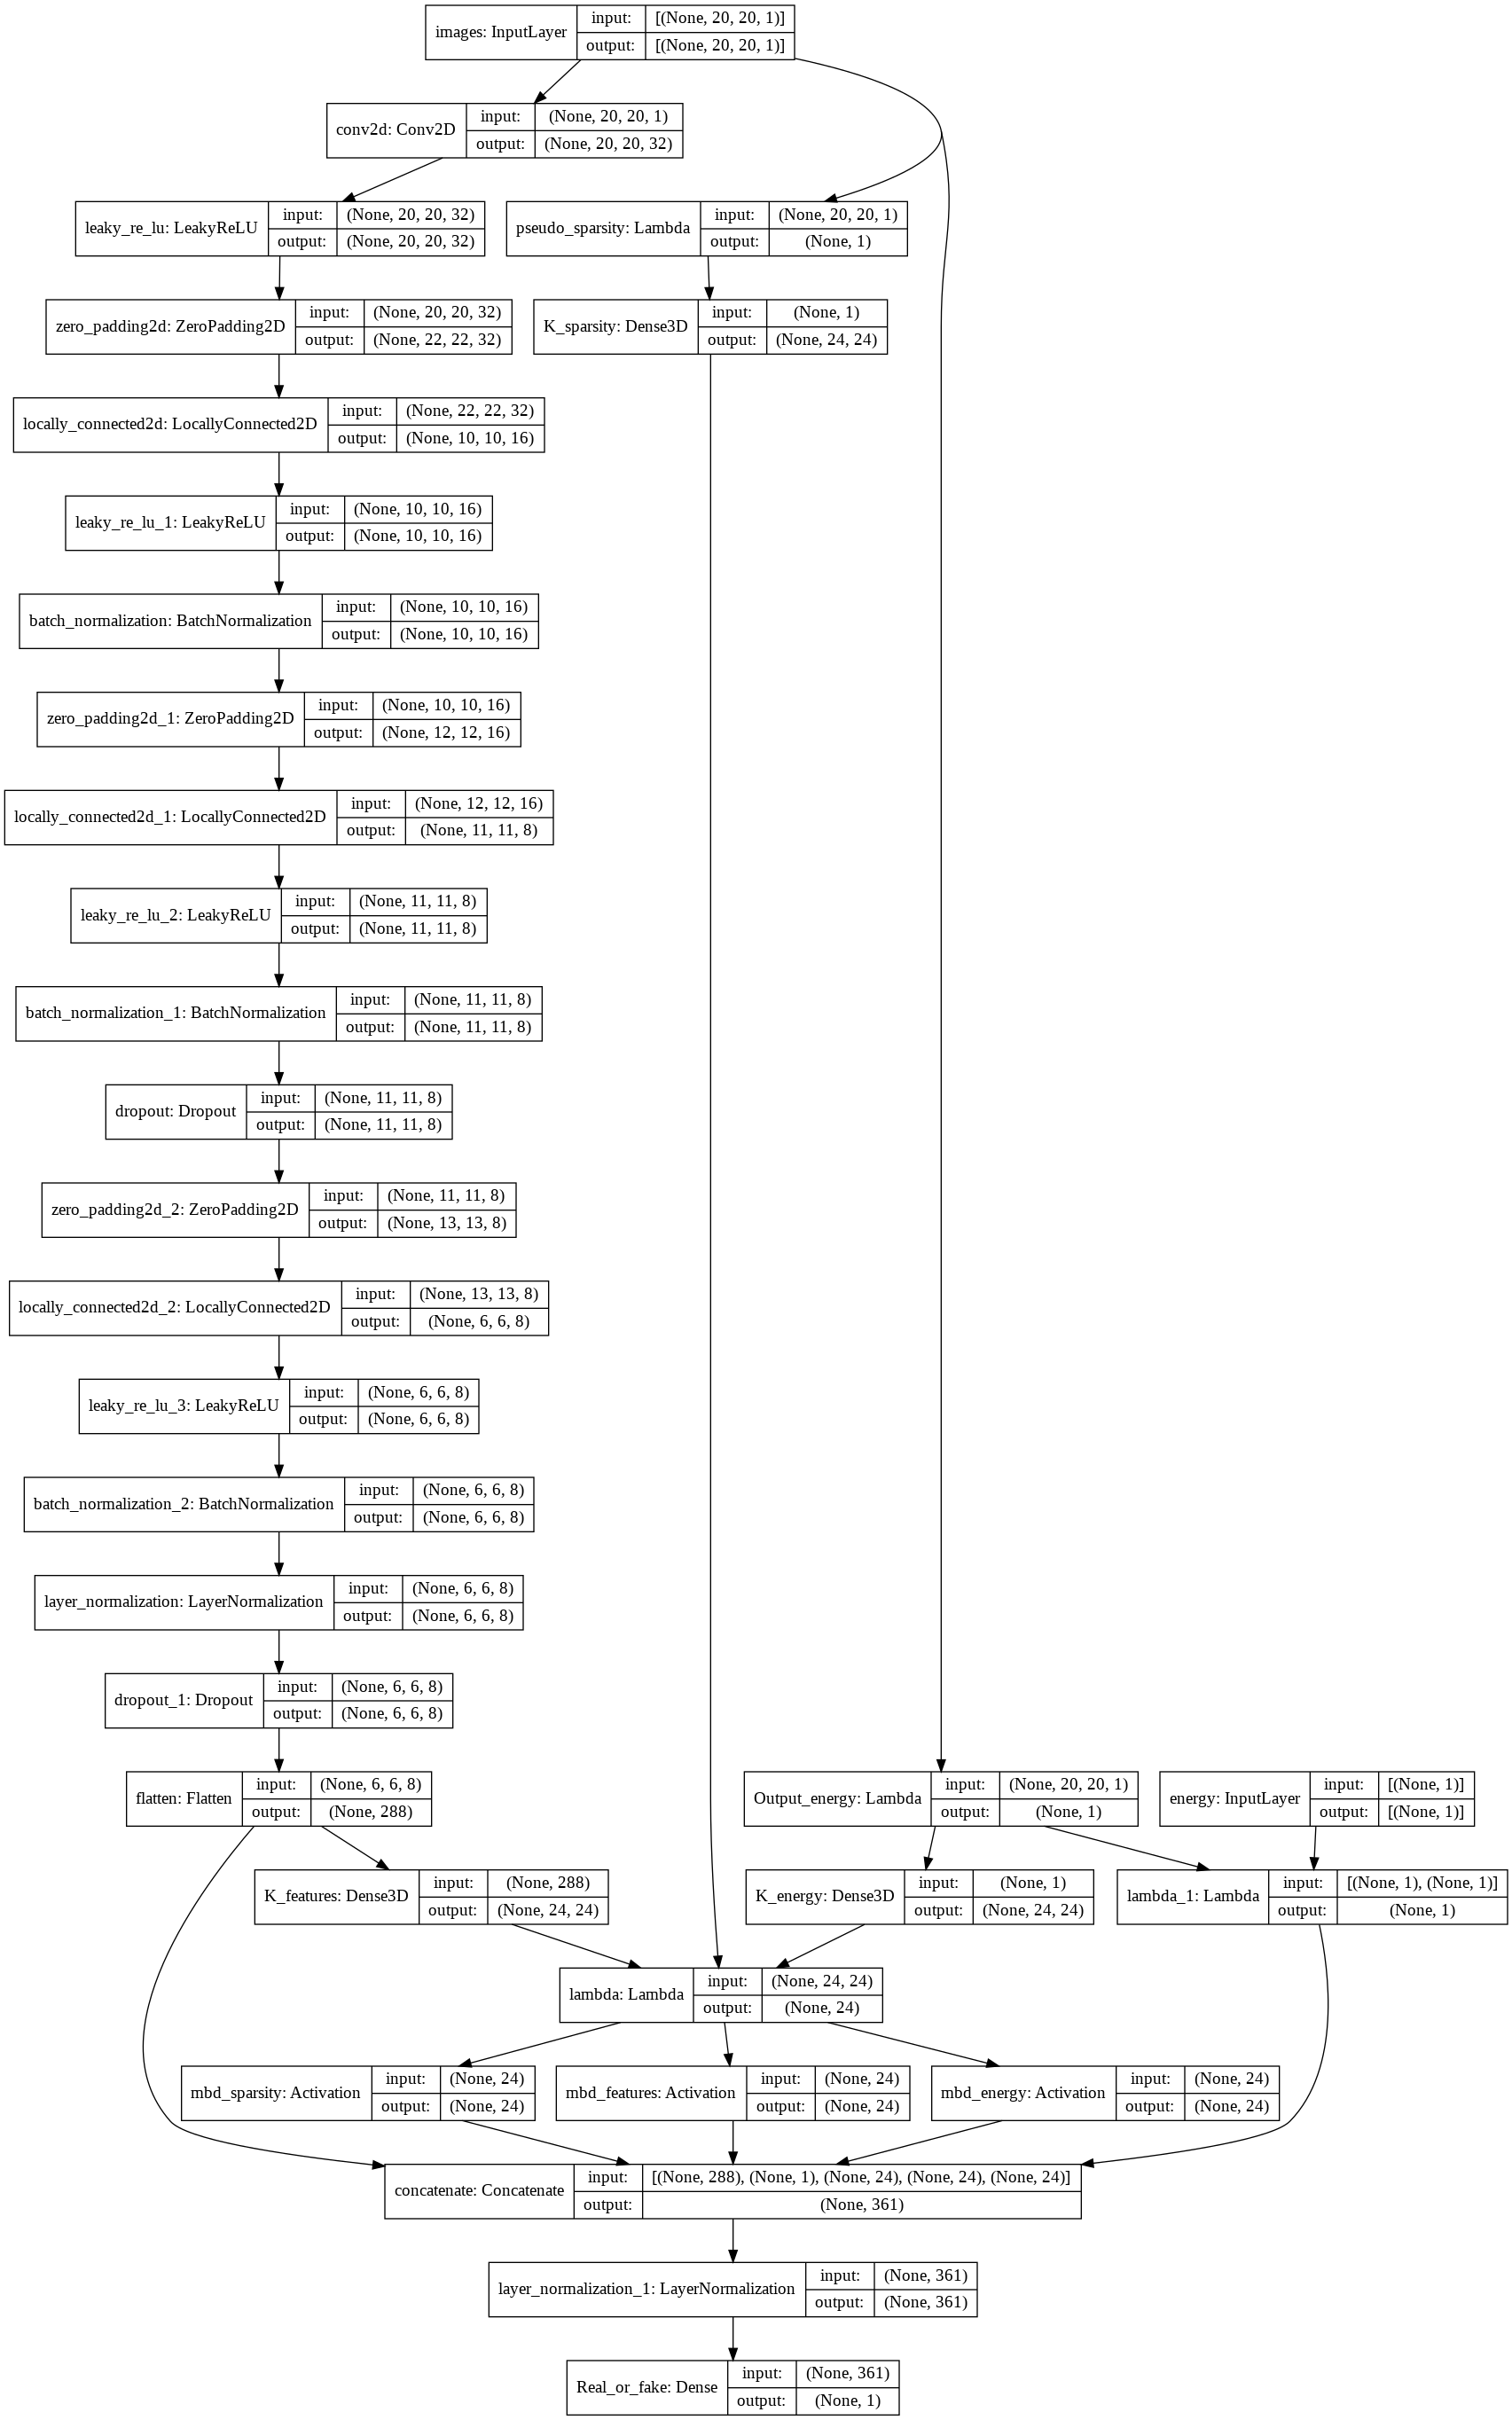

In [108]:
def build_discriminator():

    #Input
    calorimeter = Input(shape=[20,20,1],name='images')
    input_energy = Input(shape=(1,),name='energy')
    output_energy = calculate_energy(calorimeter)
    discriminator_inputs = [calorimeter, input_energy]

    #CNN
    x = Conv2D(32, (2, 2), padding='same')(calorimeter)
    x = LeakyReLU()(x)

    x = ZeroPadding2D((1, 1))(x)
    #x = LocallyConnected2D(16, (3, 3), padding='valid', strides=(1, 2))(x)
    x = LocallyConnected2D(16, (3, 3), padding='valid', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

    x = ZeroPadding2D((1, 1))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)

    x = ZeroPadding2D((1, 1))(x)
    #x = LocallyConnected2D(8, (2, 2), padding='valid', strides=(1, 2))(x)
    x = LocallyConnected2D(8, (2, 2), padding='valid', strides=(2, 2))(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = LayerNormalization()(x)
    #x = MinibatchStdev(name='feature_stdev')(x)
    #Maybe it will be helpful to use LN after CNN, so the feature learned by CNN is not sabotoged.
    x = Dropout(0.2)(x)
    #x = MinibatchStdev()(x)
    x = Flatten()(x)
    minibatch_featurizer = Lambda(minibatch_discriminator,
                                      output_shape=minibatch_output_shape)  
    nb_features = 24
    vspace_dim = 24
    K_features = Dense3D(nb_features, vspace_dim, name='K_features')(x)
    mbd_features = Activation('tanh', name='mbd_features')(minibatch_featurizer(K_features))
    

    #features = [x]
    #features.append(mbd_features)
    sparsity_detector = Lambda(sparsity_level, sparsity_output_shape, name='pseudo_sparsity')
    empirical_sparsity = sparsity_detector(calorimeter)
    #features.append(empirical_sparsity)
    K_sparsity = Dense3D(nb_features, vspace_dim, name='K_sparsity')(empirical_sparsity)
    mbd_sparsity = Activation('tanh', name='mbd_sparsity')(minibatch_featurizer(K_sparsity))


    
    #sparsity = calculate_sparsity(calorimeter)
    #minibatch_featurizer = Lambda(minibatch_discriminator,
    #                                output_shape=minibatch_output_shape)
    K_energy = Dense3D(nb_features, vspace_dim, name='K_energy')(output_energy)
    #energy_too_big = Lambda(lambda x: 20 * K.cast(x > 8, K.floatx()))(output_energy)
    mbd_energy = Activation('tanh', name='mbd_energy')(minibatch_featurizer(K_energy))
    energy_well = Lambda(lambda x: K.abs(x[0]-x[1]))([output_energy, input_energy])
    #well_too_big = Lambda(lambda x: 10 * K.cast(x > 3, K.floatx()))(energy_well)
    #redundent_energy = Lambda(lambda x: x[0]-x[1])([output_energy, input_energy])
    #positive_redundent = Lambda(lambda x: K.cast(x > 0, K.floatx()))(redundent_energy)

    p = concatenate([
                    #concatenate(features),
                    x,
                    energy_well,
                    mbd_features,
                    mbd_energy,
                    mbd_sparsity,
                    #well_too_big,
                    #redundent_energy,
                    #positive_redundent,
                    #empirical_sparsity,
                    #trans_outputs,
    ])

    p = LayerNormalization()(p)
    #p = Dense(30)(p)
    '''
    ##################################################################################################
    #features = [x]
    sparsity_detector = Lambda(sparsity_level, sparsity_output_shape, name='pseudo_sparsity')
    empirical_sparsity = sparsity_detector(calorimeter)
    empirical_sparsity = MinibatchVariableStdev(name='sparsity_stdev')(empirical_sparsity)
    output_energy_stdev = MinibatchVariableStdev(name='energy_stdev')(output_energy)
    p = concatenate([
         x,
         empirical_sparsity,
         output_energy_stdev,
    ])
    ##################################################################################################
    '''
    fake = Dense(1, name='Real_or_fake')(p)
    #fake = Dense(1, name='Real_or_fake')(x)
    discriminator_outputs = [fake,
                            output_energy,
                            ]

    discriminator = Model(discriminator_inputs, discriminator_outputs, name='Discriminator_model')
    return discriminator

d_model = build_discriminator()
d_model.summary()
keras.utils.plot_model(d_model, show_shapes=True)

## Generator

Model: "Generator_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
z (InputLayer)                  [(None, 1024)]       0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 17424)        17859600    z[0][0]                          
__________________________________________________________________________________________________
reshape (Reshape)               (None, 22, 22, 36)   0           dense[0][0]                      
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 22, 22, 16)   2320        reshape[0][0]                    
____________________________________________________________________________________

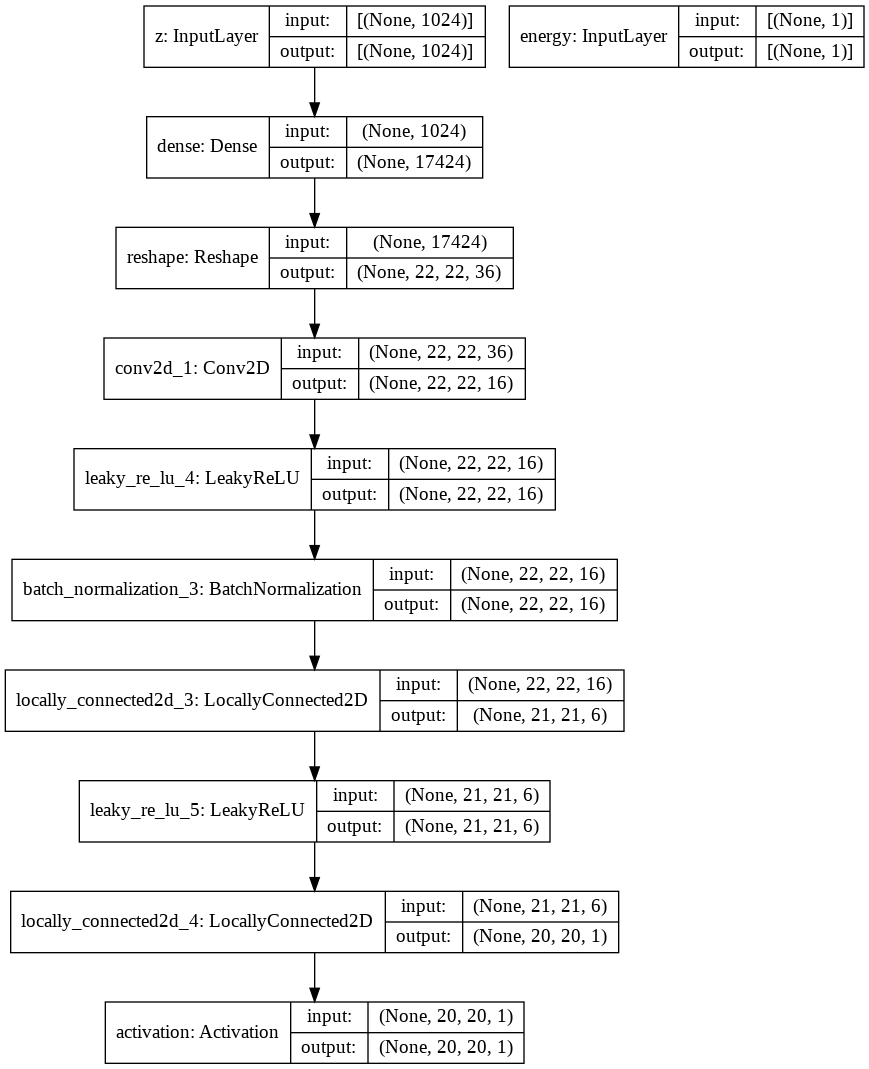

In [109]:
def upsample_block(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    up_size=(2, 2),
    padding="same",
    use_bn=False,
    use_bias=True,
    use_dropout=False,
    drop_value=0.3,
    ):
    x = UpSampling2D(up_size)(x)
    x = Conv2D(
        filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias
        )(x)

    if use_bn:
        x = BatchNormalization()(x)

    if activation:
        x = activation(x)
    if use_dropout:
        x = Dropout(drop_value)(x)
    return x


def build_generator(nb_rows = 20, nb_cols = 20):
    #Input
    latent = Input(shape=(latent_size, ), name='z')
    input_energy = Input(shape=(1, ), dtype='float32', name='energy')
    generator_inputs = [latent, input_energy]

    h = Lambda(lambda x: x[0] * x[1])([latent, input_energy])
    h = latent

    #Network

    if g_network_type == "UpSampling":

        x = Dense(3 * 3 * 256, use_bias=False)(h)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.2)(x)

        x = Reshape((3, 3, 256))(x)
        x = upsample_block(
            x,
            128,
            LeakyReLU(0.2),
            strides=(1, 1),
            use_bias=False,
            use_bn=True,
            padding="same",
            use_dropout=False,
        )
        x = upsample_block(
            x,
            64,
            LeakyReLU(0.2),
            strides=(1, 1),
            use_bias=False,
            use_bn=True,
            padding="same",
            use_dropout=False,
        )
        #x = upsample_block(x, 1, Activation("sigmoid"), strides=(1, 1), use_bias=False, use_bn=True)
        #x = Lambda(lambda x: 8*x)(x)

        x = upsample_block(
            x, 1, Activation(final_layer_activation), strides=(1, 1), use_bias=False, use_bn=True
        )
        image = Cropping2D((2, 2))(x)
    
    else :

        x = Dense((nb_rows + 2) * (nb_cols + 2) * 36)(h)
        x = Reshape((nb_rows + 2, nb_cols + 2, 36))(x)

        x = Conv2D(16, (2, 2), padding='same', kernel_initializer='he_uniform')(x)
        x = LeakyReLU(alpha=0.03)(x)
        x = BatchNormalization()(x)

        x = LocallyConnected2D(6, (2, 2), kernel_initializer='he_uniform')(x)
        x = LeakyReLU(alpha=0.03)(x)

        x = LocallyConnected2D(1, (2, 2), 
                            #use_bias=False,
                            kernel_initializer='glorot_normal'
                            #kernel_initializer=initializers.RandomUniform(minval=-0.1, maxval=-0.01, seed=None)
                            #kernel_initializer=initializers.RandomNormal(mean=-10.0, stddev=0.05, seed=None)
                            )(x)

        #image = Activation("softplus")(x)
        
        image = Activation(final_layer_activation)(x)
        
        #x = Activation("sigmoid")(x)
        #image = Lambda(lambda x: 8*x)(x)
    
    #Map (0,1) to (0,8) GeV
    #image = Lambda(lambda x: 8*x)(x)

    generator = Model(generator_inputs, image, name='Generator_model')

    return generator

g_model = build_generator()
g_model.summary()
keras.utils.plot_model(g_model, show_shapes=True)

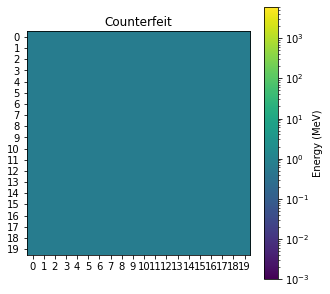

tf.Tensor([[277.2338]], shape=(1, 1), dtype=float32)
[<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-1.5814687]], dtype=float32)>, <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[277.2338]], dtype=float32)>]


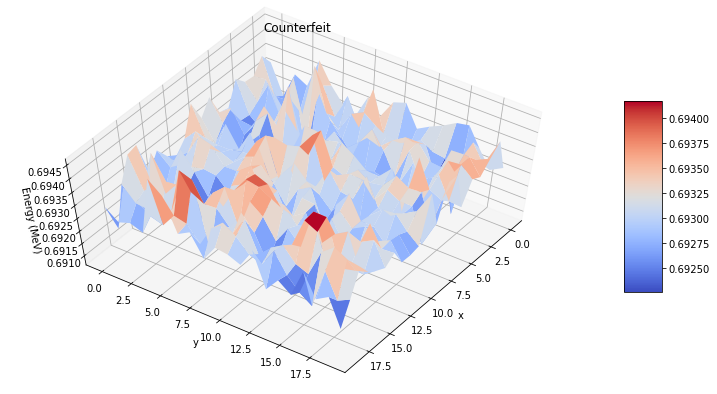

In [110]:
random_latent_vectors = tf.random.normal(shape=(1, latent_size))
real_input_energies = 8
g_inputs = {
    'z':random_latent_vectors, 
    'energy':real_input_energies
    }

#g_inputs = [random_latent_vectors, real_input_energies]
fake_images = g_model(g_inputs)
plot_2D_image(fake_images[0,:,:,0],-1)
plot_3D_image(fake_images[0,:,:,0],-1)
print(single_layer_energy(fake_images))
print(d_model([fake_images, real_input_energies]))

# WGAN model

In [118]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=1,
        generator_extra_steps=2,
        gp_weight=10.0,
        E_loss_weight = 10.0,
        #LOGAN
        z_alpha = z_alpha,
        beta = z_beta
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_size
        self.d_steps = discriminator_extra_steps
        self.g_steps = generator_extra_steps
        self.gp_weight = gp_weight
        self.E_loss_weight = E_loss_weight
        #LOGAN
        self.z_alpha = z_alpha
        self.beta = beta


    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, E_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.E_loss_fn = E_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images, input_energies):
        """ Calculates the gradient penalty.

        This loss is calculated on an interpolated image
        and added to the discriminator loss.
        """
        # Get the interpolated image
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            # 1. Get the discriminator output for this interpolated image.
            d_inputs = [interpolated, input_energies]
            pred, _ = self.discriminator(d_inputs, training=True)

        # 2. Calculate the gradients w.r.t to this interpolated image.
        grads = gp_tape.gradient(pred, [interpolated])[0]
        # 3. Calculate the norm of the gradients.
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def GD(self, z_gradient):
        delta_z = self.z_alpha * z_gradient
        return delta_z

    def NGD(self, z_gradient):
        norm_sq = tf.reduce_sum(tf.square(z_gradient))
        # delta_z = alpha / (beta + ||g||^2) * g
        delta_z = (self.z_alpha / (self.beta + norm_sq)) * z_gradient
        return delta_z

    def train_step(self, train_data):
        real_images = train_data['images']
        real_input_energies = train_data['energy']

        #if isinstance(real_images, tuple):
        #    real_images = real_images[0]
        

        
        # Get the batch size
        batch_size = tf.shape(real_images)[0]

    
        #random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_latent_vectors = tf.random.uniform(shape=(batch_size, self.latent_dim), minval=-1, maxval=1)
        
        #LOGAN
        if use_latent_optimization:
            ################################################
            with tf.GradientTape() as tape:
                
                tape.watch(random_latent_vectors)
                # Generate fake images using the generator
                g_inputs = {
                    'z':random_latent_vectors,
                    'energy':real_input_energies}
                generated_images = self.generator(g_inputs, training=True)
                # Get the discriminator logits for fake images
                d_inputs = {
                    'images':generated_images,
                    'energy':real_input_energies
                }
                
                gen_img_logits, output_energies = self.discriminator(d_inputs, training=True)

            z_gradient = tape.gradient(gen_img_logits, random_latent_vectors)
            

            #GD
            #random_latent_vectors -= self.GD(z_gradient)

            #NGD
            random_latent_vectors = tf.clip_by_value(random_latent_vectors+self.NGD(z_gradient), clip_value_min=-1, clip_value_max=1)
            #random_latent_vectors  =  random_latent_vectors+self.NGD(z_gradient)
            ################################################
        for i in range(self.g_steps):    
            # Train the generator
            # Get the latent vector

            with tf.GradientTape() as tape:
                g_inputs = {
                    'z':random_latent_vectors,
                    'energy':real_input_energies}
                generated_images = self.generator(g_inputs, training=True)
                # Get the discriminator logits for fake images
                d_inputs = {
                    'images':generated_images,
                    'energy':real_input_energies
                }
                
                gen_img_logits, output_energies = self.discriminator(d_inputs, training=True)
                # Calculate the generator loss
                g_cost = self.g_loss_fn(gen_img_logits)
                E_loss = self.E_loss_fn(real_input_energies, output_energies)
        
                g_loss = g_cost + E_loss * self.E_loss_weight


            # Get the gradients w.r.t the generator loss
            gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
            # Update the weights of the generator using the generator optimizer
            self.g_optimizer.apply_gradients(
                zip(gen_gradient, self.generator.trainable_variables)
            )

        for i in range(self.d_steps):

            g_inputs = {
                'z':random_latent_vectors, 
                'energy':real_input_energies
                }
            with tf.GradientTape() as tape:
                # Get the logits for the real images
                #d_inputs = [real_images, real_input_energies]
                real_logits, _ = self.discriminator(train_data, training=True)

                # Generate fake images from the latent vector
                fake_images = self.generator(g_inputs, training=True)
                # Get the logits for the fake images
                d_inputs = {
                    'images': fake_images, 
                    'energy': real_input_energies}
                fake_logits, _ = self.discriminator(d_inputs, training=True)
                

                # Calculate the discriminator loss using the fake and real image logits
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                # Calculate the gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images, real_input_energies)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * self.gp_weight

            # Get the gradients w.r.t the discriminator loss
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            # Update the weights of the discriminator using the discriminator optimizer
            self.d_optimizer.apply_gradients(
                zip(d_gradient, self.discriminator.trainable_variables)
            )
        
        return {"d_loss": d_loss,"d_cost": d_cost, "gp": gp,"g_loss": g_loss, "g_cost": g_cost,"E_loss": E_loss}

In [119]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self):
        self.Event = np.random.randint(sizes[0])
        #self.seed_noise = np.random.normal(0, 1, (1, latent_size))
        self.seed_noise = np.random.uniform(-1, 1, (1, latent_size))
        #self.seed_energy = np.array(Energy[self.Event]).reshape(1,1)
        self.seed_energy = 8
        self.seed = [self.seed_noise, self.seed_energy]
        self.losses = pd.DataFrame(columns = ["d_loss","d_cost", "gp", "g_loss", "g_cost","E_loss"])
        self.losses_iter = pd.DataFrame(columns = ["d_loss","d_cost", "gp", "g_loss", "g_cost","E_loss"])
        self.batch_num = 0

    
    def on_train_batch_end(self, batch, logs=None):
        self.batch_num += 1
        if self.batch_num%100 == 1:
            generated_image = self.model.generator(self.seed)
            test_generated_image = 1000 * generated_image[0,:,:,0]
            display.clear_output(wait=True)
            plot_loss(self.losses)
            test_generated_image = cut_image(test_generated_image, energy_cut)
            plot_3D_image(test_generated_image, -1)
            plot_2D_image(test_generated_image, -1)
            plot_loss(self.losses_iter,x_title='Train step', fig_width=30, fig_height=10)
            print("The output energy is ",1000 * single_layer_energy(generated_image))
            print(np.max(test_generated_image))
            print("Logs of batch {}: ".format(batch),logs)
            # Get the current learning rate from model's optimizer.
            #lr = float(K.get_value(wgan.d_optimizer.learning_rate))
            #print("The learning rate of discriminator is {}".format(lr))
        self.losses_iter.loc[len(self.losses_iter)] = logs

    

    def on_epoch_end(self, epoch, logs=None):
        self.losses.loc[len(self.losses)] = logs
        self.model.generator.save_weights('{0}{1:03d}.hdf5'.format(g_pfx, len(self.losses)),
                                    overwrite=True)
        self.model.discriminator.save_weights('{0}{1:03d}.hdf5'.format(d_pfx, len(self.losses)),
                                        overwrite=True)
        generated_image = self.model.generator(self.seed)
        test_generated_image = 1000 * generated_image[0,:,:,0]
        display.clear_output(wait=True)
        '''
        if np.min(test_generated_image) != 0 :
            min_non_zero_cell = np.min(test_generated_image[np.nonzero(test_generated_image)])
        else :
            min_non_zero_cell = 0
        print("The min is {}".format(min_non_zero_cell))
        '''
        total_epoch = len(self.losses)
        plot_loss(self.losses)
        #test_generated_image = np.where(test_generated_image > energy_cut, test_generated_image, 0)
        test_generated_image = cut_image(test_generated_image, energy_cut)
        plot_3D_image(test_generated_image, total_epoch)
        plot_2D_image(test_generated_image, total_epoch)
        
        

        print("The output energy is ",1000 * single_layer_energy(generated_image))
        print(np.max(test_generated_image))
        print("Logs of epoch{}: ".format(epoch),logs)
        self.batch_num = 0
        #Reset the loss for iter per batch
        self.losses_iter = pd.DataFrame(columns = ["d_loss","d_cost", "gp", "g_loss", "g_cost","E_loss"])


In [120]:
#generator_optimizer = Adam(2e-4, beta_1=0.5, beta_2=0.9)
generator_optimizer = Nadam()

d_lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=disc_lr,
    decay_steps=decay_steps,
    decay_rate=decay_rate)
d_lr_schedule = keras.optimizers.schedules.PolynomialDecay(initial_learning_rate=disc_lr, decay_steps=decay_steps, end_learning_rate=end_learning_rate, 
                                                           power=0.5,cycle=True, name=None)
discriminator_optimizer = Adam(learning_rate=d_lr_schedule, beta_1=0.5, beta_2=0.9)
#discriminator_optimizer = Nadam(learning_rate=disc_lr)

# Define the loss functions for the discriminator,
# which should be (fake_loss - real_loss).
# We will add the gradient penalty later to this loss function.
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

# Define the loss functions for the generator.
def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def energy_loss_function(input_energy, output_energy):
    energy_surplus = output_energy - input_energy
    energy_gap = input_energy - output_energy
    loss =  tf.reduce_mean(tf.where(energy_surplus>0, energy_surplus, 0)) 
    #+ E_factor * tf.reduce_mean(tf.where(energy_gap>0, energy_gap, 0))
    return loss

def energy_loss(input_energy, output_energy):
    return tf.reduce_mean(output_energy - input_energy)

# Instantiate the customer `GANMonitor` Keras callback.
cbk = GANMonitor()

# Instantiate the WGAN model.
wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=latent_size,
    discriminator_extra_steps=discriminator_extra_steps,
    generator_extra_steps=generator_extra_step,
    E_loss_weight = 10.0
)

# Compile the WGAN model.
wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    E_loss_fn=energy_loss_function
)

# Train

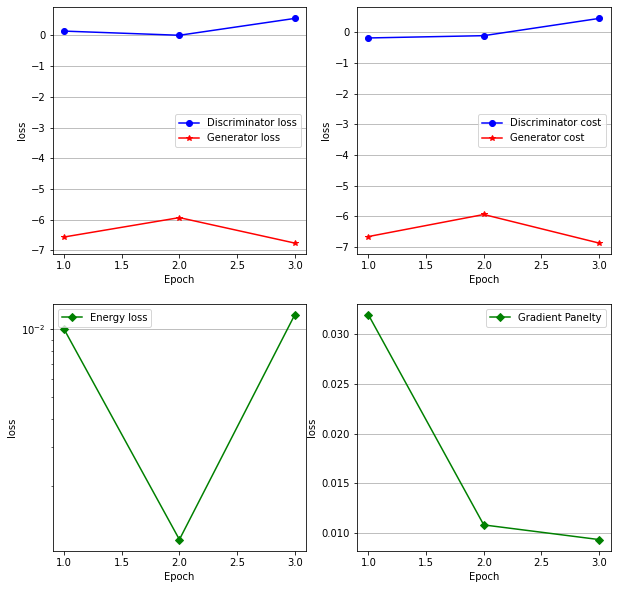

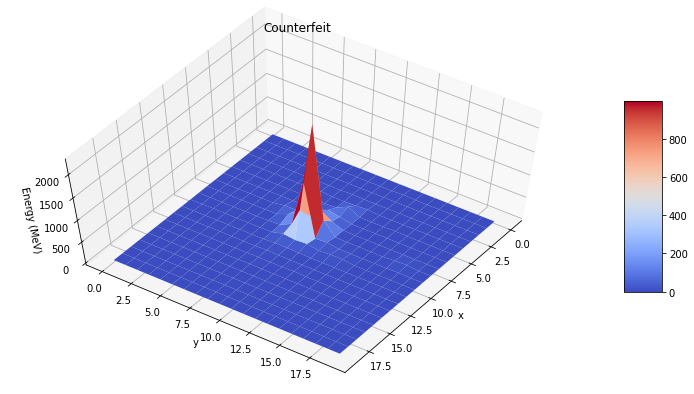

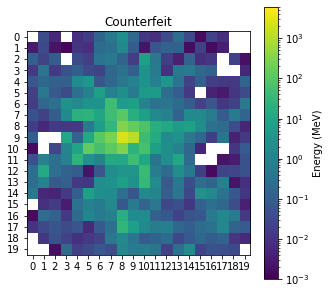

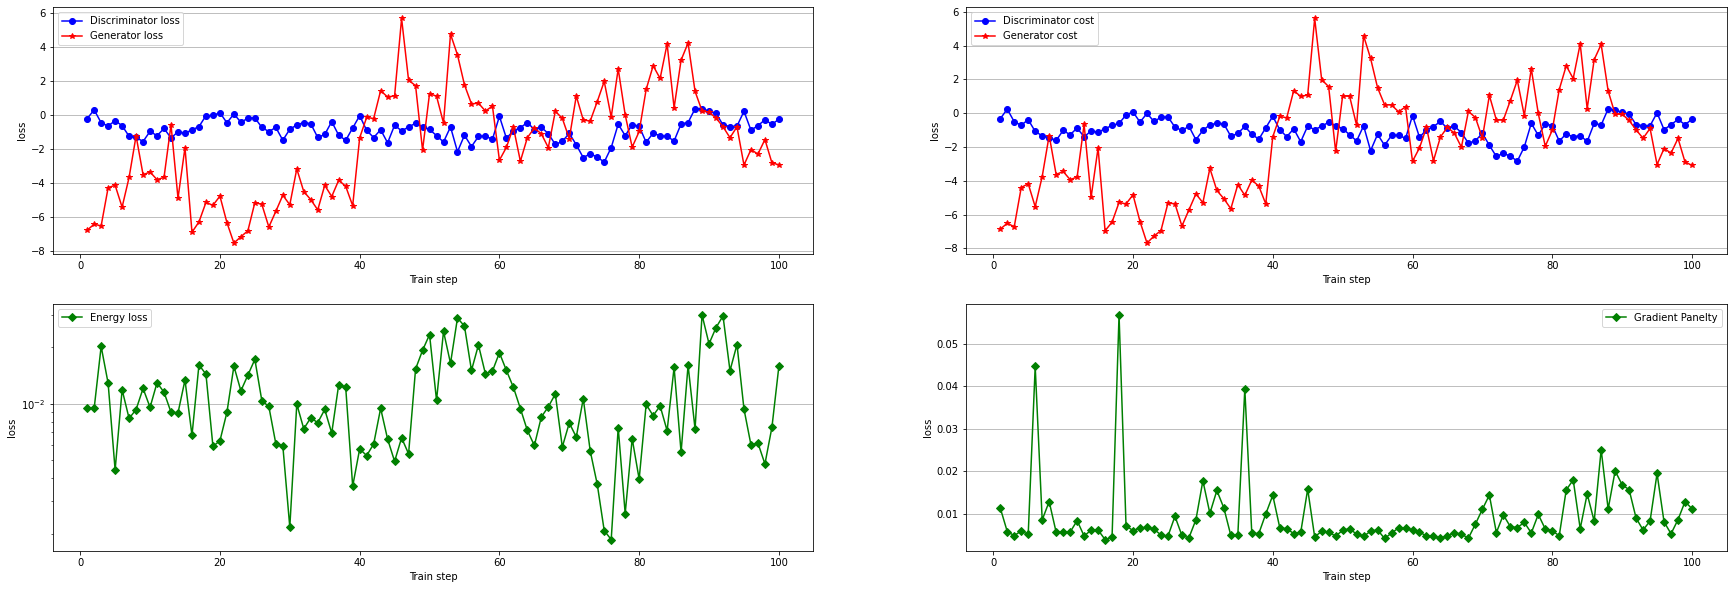

The output energy is  tf.Tensor([[6076.8647]], shape=(1, 1), dtype=float32)
2278.3796
Logs of batch 100:  {'d_loss': -0.49668607115745544, 'd_cost': -0.6589798927307129, 'gp': 0.016229381784796715, 'g_loss': -3.3984646797180176, 'g_cost': -3.5205864906311035, 'E_loss': 0.012212169356644154}
122/803 [===>..........................] - ETA: 7:59 - d_loss: -0.8064 - d_cost: -0.8975 - gp: 0.0091 - g_loss: -2.8481 - g_cost: -2.9665 - E_loss: 0.0118

In [ ]:
if not Model_to_load:
    epochs = 10
    wgan.fit(train_dataset.prefetch(tf.data.AUTOTUNE),
             #batch_size=BATCH_SIZE,
             #Somehow this give a warning
             epochs=epochs,
             callbacks=[cbk,
                        #tensorboard_callback,
                        #lr_callback
                        ]
            )

In [ ]:
print(wgan.d_optimizer.learning_rate)
print(wgan.g_optimizer.learning_rate)           

<tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>


In [ ]:
#g_model.load_weights("/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/Models/2021-05-15_16:26:03WGANgenerator_['Inclusive'].hdf5")

In [51]:
print(keras.__version__)

2.5.0


# Load weights

In [21]:
if Model_to_load:
    g_model.load_weights(Model_to_load)
    d_model.load_weights(d_model_to_load)
path = "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/Models/"


g_model.load_weights('params_generator_epoch_020.hdf5')
d_model.load_weights('params_discriminator_epoch_020.hdf5')

#g_model.load_weights(path+'2021-07-15_02:42:21LOGANgenerator_GMM_Targe_8e5.hdf5')
#d_model.load_weights(path+'2021-07-15_02:42:21LOGANdiscriminator_GMM_Targe_8e5.hdf5')

# Test model

In [22]:
#@title Cut on variables { run: "auto" }
cut_on_variables = False #@param ["True", "False"] {type:"raw"}
test_size_1 = 1000000 #@param {type:"integer"}

## Test functions

In [23]:
def heat_map(Input_energy, Output_energy, xbin=70, ybin=70):
    fig = plt.figure(num=1, figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.set_xlim(0,9000)
    ax.set_ylim(0,9000)
    ax.hist2d(Input_energy, Output_energy, bins=(xbin, ybin), cmap=plt.cm.jet, range=((0,9000),(0,9000)))
    ax.set_xlabel('Input energy (MeV)')
    ax.set_ylabel('Layer energy sum (MeV)')
    plt.show()

def plot_hist(image, bin=50):
    plt.hist(image, bins=bin, alpha=0.75)
    plt.xlabel('Energy (MeV)')
    plt.show()


def plot_compare_hist(real_images, fake_images, title,y_log_scale = True, x_log_scale=False):
    colors = matplotlib.cm.gnuplot2(np.linspace(0.2, 0.8, 3))
    plt.figure(figsize=(10, 10))
    plt.hist(real_images, bins=100,histtype='stepfilled', density=True,linewidth=2,
                alpha=0.2, color=colors[0],
                label=r'GEANT4')
    plt.hist(fake_images, bins=100, histtype='step', density=True,linewidth=3,
                alpha=1, color=colors[0],
                label=r'GAN')
    if y_log_scale:
        plt.yscale('log')
    
    if x_log_scale:
        plt.xscale('log')
    plt.legend(loc='upper right', fontsize=20, ncol=2)
    plt.xlabel(title)
    plt.show()

In [24]:
@tf.function
def optimize_latent(random_latent_vectors, generator, discriminator):
    with tf.GradientTape() as tape:
    
        tape.watch(random_latent_vectors)
        # Generate fake images using the generator
        g_inputs = {
            'z':random_latent_vectors,
            'energy':real_input_energies}
        generated_images = generator(g_inputs, training=False)
        # Get the discriminator logits for fake images
        d_inputs = {
            'images':generated_images,
            'energy':real_input_energies
        }
        
        gen_img_logits, output_energies = discriminator(d_inputs, training=False)
    z_gradient = tape.gradient(gen_img_logits, random_latent_vectors)
    delta_z = wgan.NGD(z_gradient)
    random_latent_vectors  =  random_latent_vectors + delta_z
    #random_latent_vectors = tf.clip_by_value(random_latent_vectors+delta_z, clip_value_min=-1, clip_value_max=1)
    return random_latent_vectors

In [25]:
def generate_test_dataset(test_size = 500000, optimize = True):
    #test_noise = np.random.normal(0, 1, (test_size, latent_size))
    #test_noise = tf.random.normal(shape=(test_size, latent_size))
    #test_noise = optimize_latent(test_noise, g_model, d_model)
    if test_size > 1000000:
        test_noise = tf.concat([
                                tf.random.uniform(shape=(1000000, latent_size), minval=-1, maxval=1) for i in range(int(test_size/1000000))
        ], axis=0)
    else:
        test_noise = tf.random.uniform(shape=(test_size, latent_size), minval=-1, maxval=1)
    

    if optimize:
        
        test_batch_size = batch_size
        multiple = int(test_size/test_batch_size)
        test_noise = tf.reshape(test_noise, [multiple, test_batch_size, -1])
        #noise_dataset = tf.data.Dataset.from_tensor_slices(test_noise).batch(batch_size)
        '''
        test_noise = tf.concat([optimize_latent(
            tf.random.uniform(shape=(test_batch_size, latent_size), minval=-1, maxval=1), 
            g_model, d_model
            ) for i in tqdm(range(multiple))], axis=0)
        '''
        test_noise = tf.concat([optimize_latent(
            test_noise[i], 
            g_model, d_model
            ) for i in tqdm(range(multiple))], axis=0)
        
        #test_noise = tf.map_fn(fn=lambda z: optimize_latent(z, g_model, d_model), elems=test_noise)
        #test_noise = tf.reshape(test_noise, [multiple*test_batch_size, -1])
    #test_sampled_energies = np.random.choice(Energy, test_size)
    test_sampled_energies = np.ones(test_size) * 8
    plot_hist(np.array(test_noise).flatten())
    test_dataset = (
        tf.data.Dataset.from_tensor_slices({
            'z' :test_noise, 
            'energy' :test_sampled_energies
            })
        .batch(batch_size)
        )
    return test_dataset, test_sampled_energies

## Test on 8GeV

### Generate images

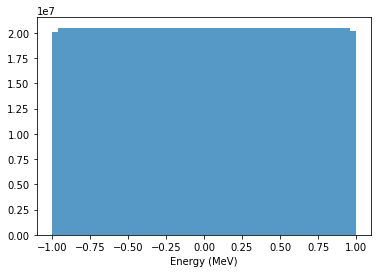

2000/2000 [==============================] - 50s 18ms/step


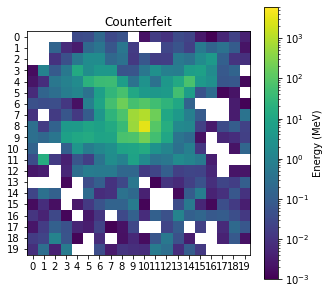

8.0
CPU times: user 4min 38s, sys: 2min 4s, total: 6min 43s
Wall time: 6min 18s


In [26]:
%%time

#Use our model to generate image and convert to the scale of MeV
#test_size_1 = 498197
#test_size_1 = 4000000
test_dataset_1, test_sampled_energies_1 = generate_test_dataset(test_size = test_size_1, 
                                                                optimize = use_latent_optimization
                                                                #optimize = False
                                                                )
test_generated_image_1 = 1000 * g_model.predict(test_dataset_1, verbose=1)#GeV -> MeV

#aux_model = "/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/Models/2021-05-30_00:59:02WGANgenerator_['Inclusive_cut_7GeV'].hdf5"
aux_model = None
if aux_model:
    g_model.load_weights(aux_model)
    #test_size_2 = 5000
    test_size_2 = 1803


    test_dataset_2, test_sampled_energies_2 = generate_test_dataset(test_size = test_size_2)
    test_generated_image_2 = 1000 * g_model.predict(test_dataset_2, verbose=1)#GeV -> MeV
    test_generated_image = np.concatenate((test_generated_image_1, test_generated_image_2), axis=0)
    test_sampled_energies = np.concatenate((test_sampled_energies_1, test_sampled_energies_2), axis=0)
    test_size = test_size_1 + test_size_2
else :
    test_generated_image = test_generated_image_1
    test_sampled_energies = test_sampled_energies_1
    test_size = test_size_1
plot_2D_image(cut_image(test_generated_image[0,:,:,0], energy_cut),-1)
print(test_sampled_energies[0])
#Calculated the energies 
test_generated_image = cut_image(test_generated_image, energy_cut)

In [27]:
test_generated_image_1.dtype

dtype('float32')

### Check random image

In [28]:
print(test_generated_image.shape)

(1000000, 20, 20, 1)


(500, 20, 20, 1)
(500,)


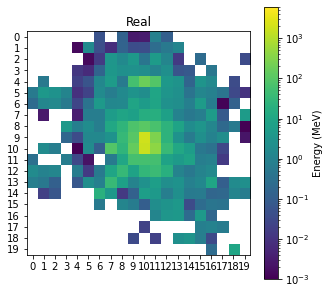

(401201, 20, 20)


In [29]:
for sample in train_dataset.take(1):
    print(sample['images'].shape)
    print(sample['energy'].shape)
    event_num = np.random.randint(len(sample['images']))
    real_image = 1000 * sample['images'][event_num,:,:,0]
    real_image = cut_image(real_image, 
                       energy_cut
                       )
    plot_2D_image(real_image,-2)
print(sizes)

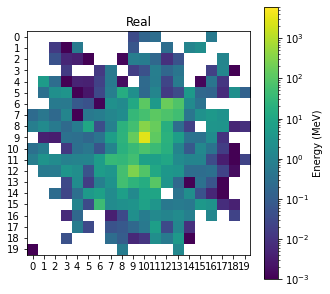

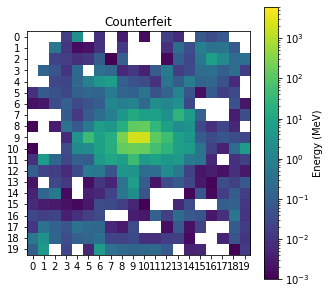

In [30]:
event_num = np.random.randint(len(test_generated_image))
fake_image = test_generated_image[event_num,:,:,0]
if hdf5_dataset:
    event_num = np.random.randint(len(ECAL_centre))
    real_image = ECAL_centre[event_num]
    plot_2D_image(real_image,-2)
fake_image = cut_image(fake_image, 
                       1e-3
                       #np.min(np.where(real_image>0,real_image,100))
                       )
plot_2D_image(fake_image, -1)

### Load variables

In [31]:
if hdf5_dataset:
    hdf5_filenames = list(particle_label.values())[0][:-5]+'_variables.hdf5'

if tfrecord_dataset:
    hdf5_filenames = list(particle_label.values())[0][:-9]+'_variables.hdf5'

print(hdf5_filenames)

/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/TrainingData/PN_ECAL_ana_4e5_variables.hdf5


In [32]:
variable_data = dd.io.load(hdf5_filenames)

In [33]:
x = 25*np.arange(-9.5,10,1)
y = x
x_coor,y_coor = np.meshgrid(x,y,indexing = 'xy')
x_coor = x_coor.reshape(-1)
y_coor = y_coor.reshape(-1)

def get_total_E(image):
    return np.sum(image)

def get_E_max(image):
    return np.max(image)

def get_frac_n(image, n):
    top_n = np.sort(image.flatten())[::-1][:n]
    return np.sum(top_n)/np.sum(image)

def get_x_moment(image):
    return np.average(x_coor,weights=image.reshape(image.size))

def get_y_moment(image):
    return np.average(y_coor,weights=image.reshape(image.size))

def get_x_sq(image):
    return np.average(x_coor**2,weights=image.reshape(image.size))

def get_y_sq(image):
    return np.average(y_coor**2,weights=image.reshape(image.size))

def get_r(image):
    return np.average(np.sqrt(x_coor**2 + y_coor**2),weights=image.reshape(image.size))

def get_sparsity(image, cut_value):
    return np.average(np.where(image>cut_value, 1, 0))

functions_of_variables = {
    'total energy': get_total_E,
    'x_moment': get_x_moment,
    'y_moment': get_y_moment,
    'x_sq': get_x_sq,
    'y_sq': get_y_sq,
    'r': get_r,
    'E_max': get_E_max,
    'pseudo-sparsity': lambda image: get_sparsity(image, energy_cut),
    'frac_50': lambda image: get_frac_n(image, 50),
    'frac_100': lambda image: get_frac_n(image, 100),
    'frac_200': lambda image: get_frac_n(image, 200)
}

In [34]:
def get_variables(func, images):
    return np.fromiter((func(x) for x in images), images.dtype)

def variable_dict(images, **functions):
    variables = {}
    for key, func in functions.items():
        variables[key] = get_variables(func, images)
    return variables

In [35]:
generated_variables = variable_dict(test_generated_image, **functions_of_variables)

In [36]:
print(generated_variables.keys())
print(variable_data.keys())
print(type(variable_data))
print(type(generated_variables))

dict_keys(['total energy', 'x_moment', 'y_moment', 'x_sq', 'y_sq', 'r', 'E_max', 'pseudo-sparsity', 'frac_50', 'frac_100', 'frac_200'])
dict_keys(['E_max', 'frac_100', 'frac_200', 'frac_50', 'pseudo-sparsity', 'r', 'total energy', 'x_moment', 'x_sq', 'y_moment', 'y_sq'])
<class 'dict'>
<class 'dict'>


In [37]:
print(test_generated_image.shape)

(1000000, 20, 20, 1)


In [38]:
selected_variables = ['total energy', 'x_moment', 'y_moment', 'x_sq', 'y_sq', 'r', 'E_max']
#selected_variables = generated_variables.keys()
target = pd.DataFrame(data={key:variable_data[key] for key in selected_variables})
original = pd.DataFrame(data={key:generated_variables[key] for key in selected_variables})
if cut_on_variables:
    for col in target.columns:
        qualified = (original[col] <= target[col].max()) & (original[col] >= target[col].min())
        original = original[qualified]
        test_generated_image = test_generated_image[qualified]

print(target.columns)
print(original.columns)
print(original.shape)
print(test_generated_image.shape)

Index(['total energy', 'x_moment', 'y_moment', 'x_sq', 'y_sq', 'r', 'E_max'], dtype='object')
Index(['total energy', 'x_moment', 'y_moment', 'x_sq', 'y_sq', 'r', 'E_max'], dtype='object')
(1000000, 7)
(1000000, 20, 20, 1)


### Install required package

In [39]:
!pip install hep_ml

### Function to plot

In [40]:
from hep_ml import reweight
from hep_ml.metrics_utils import ks_2samp_weighted
columns = original.columns
KS_data = pd.DataFrame(columns=columns)
def draw_distributions(original, target, new_original_weights, y_log_scale= True, x_log_scale=False):
    KS_values = {}
    colors = matplotlib.cm.gnuplot2(np.linspace(0.2, 0.8, 3))
    num_row = np.ceil(len(columns)/2)
    plt.figure(figsize=[20, 7*num_row])
    for id, column in enumerate(columns, 1):
        xlim = np.percentile(np.hstack([target[column]]), [0.01, 99.99])
        plt.subplot(num_row, 2, id)

        plt.hist(target[column], bins=100, histtype='stepfilled',
                 density=True,
                 linewidth=1,
                 range=(np.min(target[column]), np.max(target[column])),
                 alpha=0.2, color=colors[0],
                 label=r'DSS')
        plt.hist(original[column], weights=new_original_weights, bins=100, histtype='step',
                 density=True,
                 linewidth=2,
                 range=(np.min(target[column]), np.max(target[column])),
                 alpha=1, color=colors[0],
                 label=r'GAN')
        
        if y_log_scale:
            plt.yscale('log')
    
        if x_log_scale:
            plt.xscale('log')
        plt.legend(loc='upper right', fontsize=20, ncol=2)
        plt.title(column)
        print('KS over ', column, ' = ', ks_2samp_weighted(original[column], target[column],
                                                           weights1=new_original_weights, weights2=np.ones(len(target), dtype=float)))
        KS_values[column] = ks_2samp_weighted(original[column], target[column],
                                              weights1=new_original_weights, weights2=np.ones(len(target), dtype=float))
    return KS_values

### Original Distribution

KS over  total energy  =  0.16845213982924756
KS over  x_moment  =  0.14145702920781222
KS over  y_moment  =  0.047327873137961385
KS over  x_sq  =  0.14942034838049978
KS over  y_sq  =  0.09379656356179467
KS over  r  =  0.02846539106996404
KS over  E_max  =  0.04785515897122794
KS over  total energy  =  0.16845213982924756
KS over  x_moment  =  0.14145702920781222
KS over  y_moment  =  0.047327873137961385
KS over  x_sq  =  0.14942034838049978
KS over  y_sq  =  0.09379656356179467
KS over  r  =  0.02846539106996404
KS over  E_max  =  0.04785515897122794
0.6767745041585076


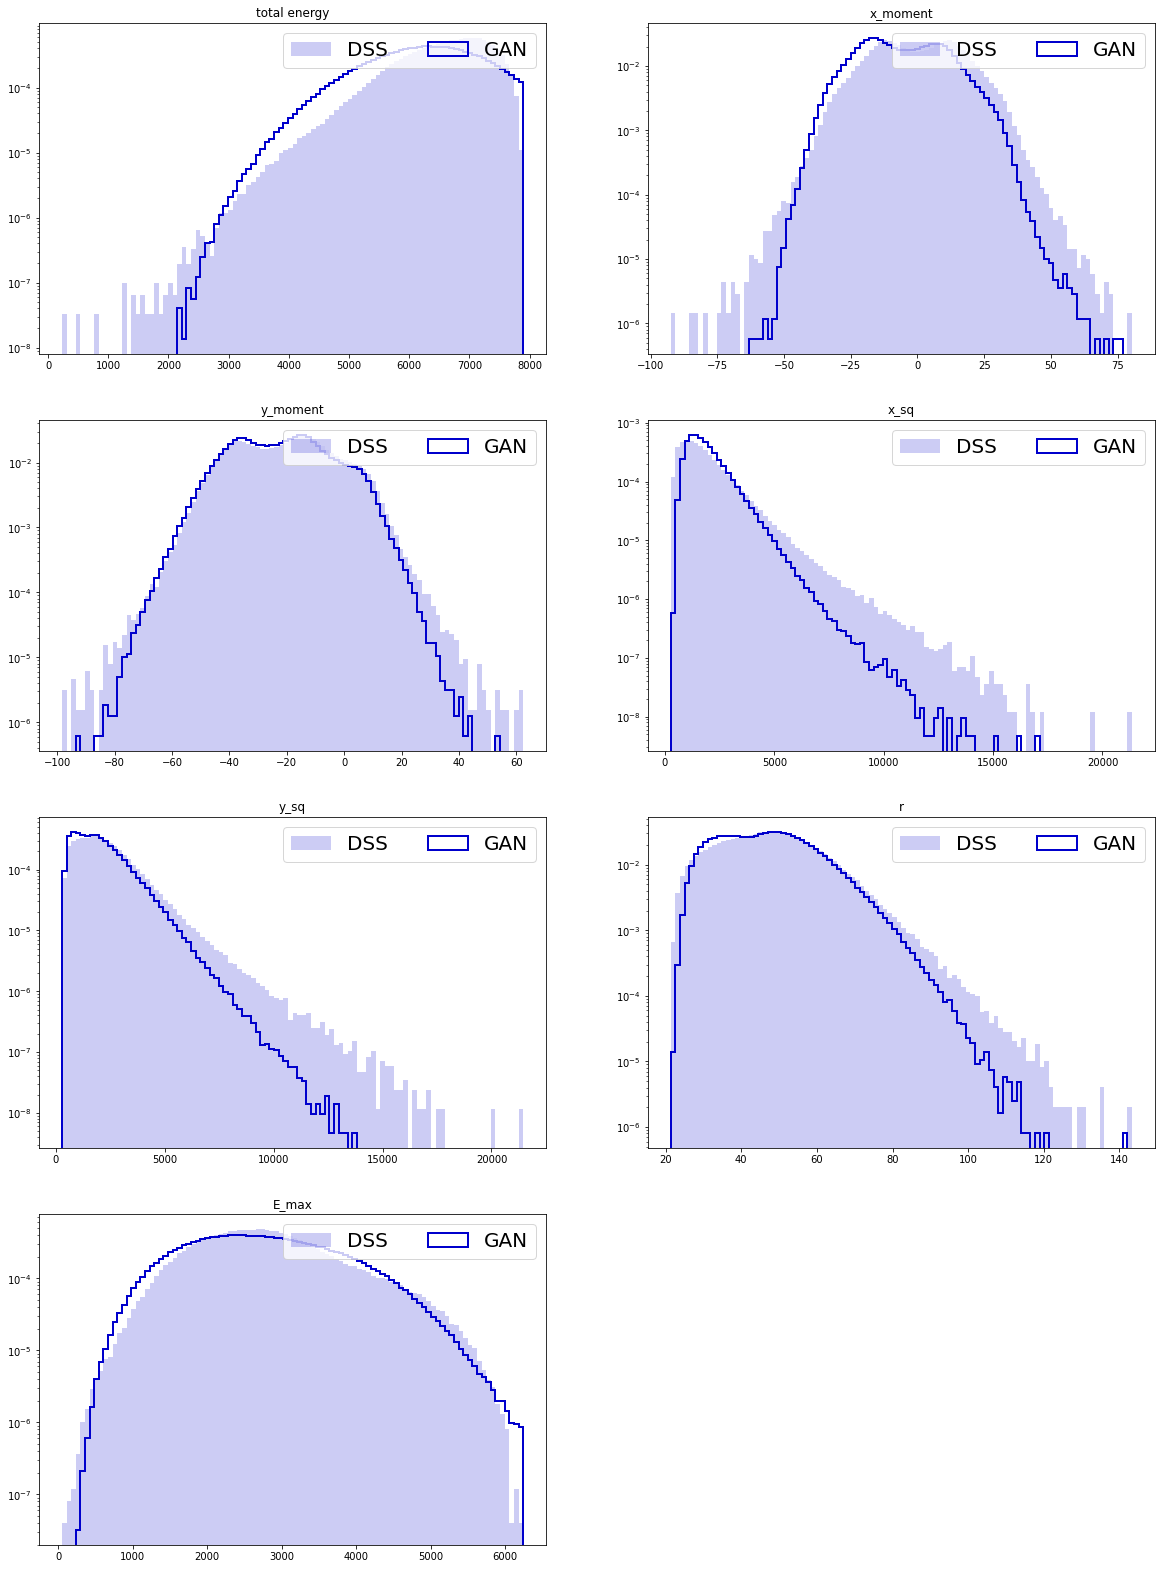

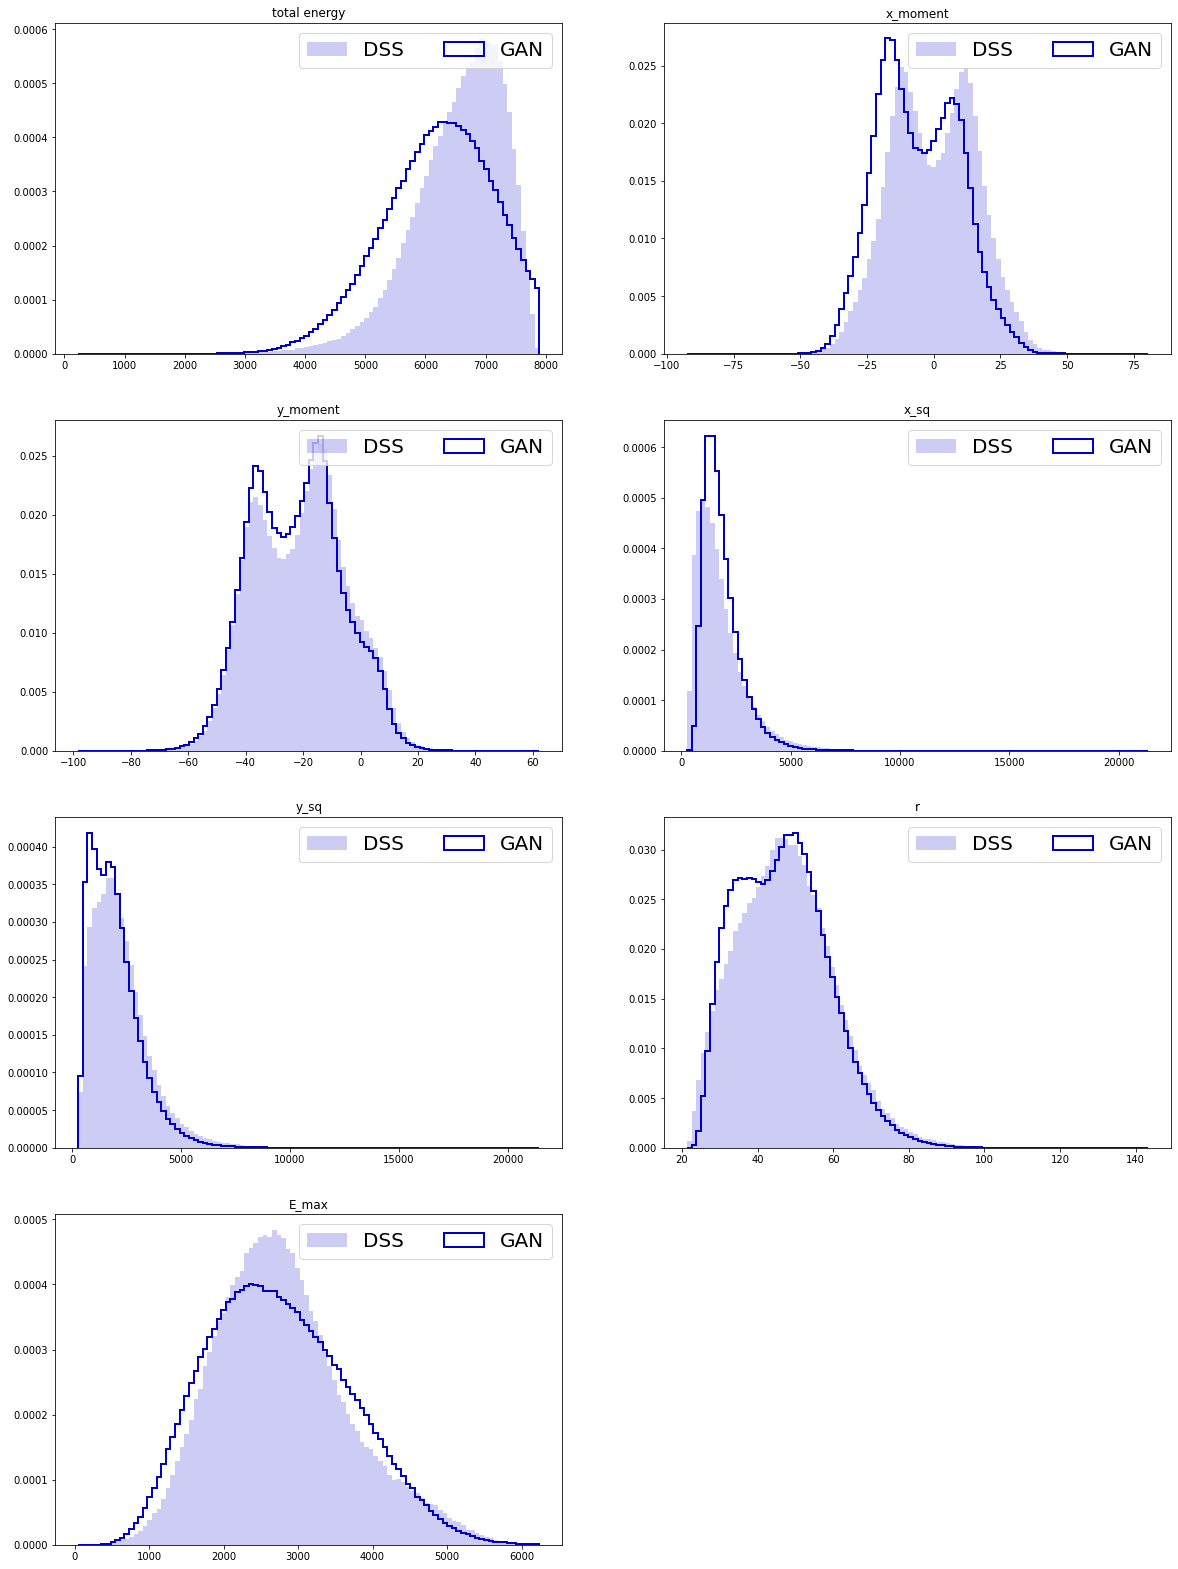

In [41]:
original_weights = np.ones(len(original))
KS_data.loc['original'] = draw_distributions(original, target, original_weights)
_ = draw_distributions(original, target, original_weights, y_log_scale=False)
print(np.sum([i for i in _.values()]))

# Reweighter

### Weights dataframa

In [42]:
weights_data = pd.DataFrame()

### Gradient Boosted Reweighter

In [43]:
reweighter = reweight.GBReweighter(n_estimators=50, learning_rate=0.1, max_depth=3, min_samples_leaf=1000,
                                   gb_args={'subsample': 0.4})

In [44]:
reweighter.fit(original, target)

GBReweighter(gb_args={'subsample': 0.4}, learning_rate=0.1,
             loss_regularization=5.0, max_depth=3, min_samples_leaf=1000,
             n_estimators=50)

In [45]:
gb_weights_test = reweighter.predict_weights(original)

KS over  total energy  =  0.04004311504383534
KS over  x_moment  =  0.03798980954869258
KS over  y_moment  =  0.04688746981632674
KS over  x_sq  =  0.04049469974413705
KS over  y_sq  =  0.036504568763333634
KS over  r  =  0.010666135341280691
KS over  E_max  =  0.035807472836635656


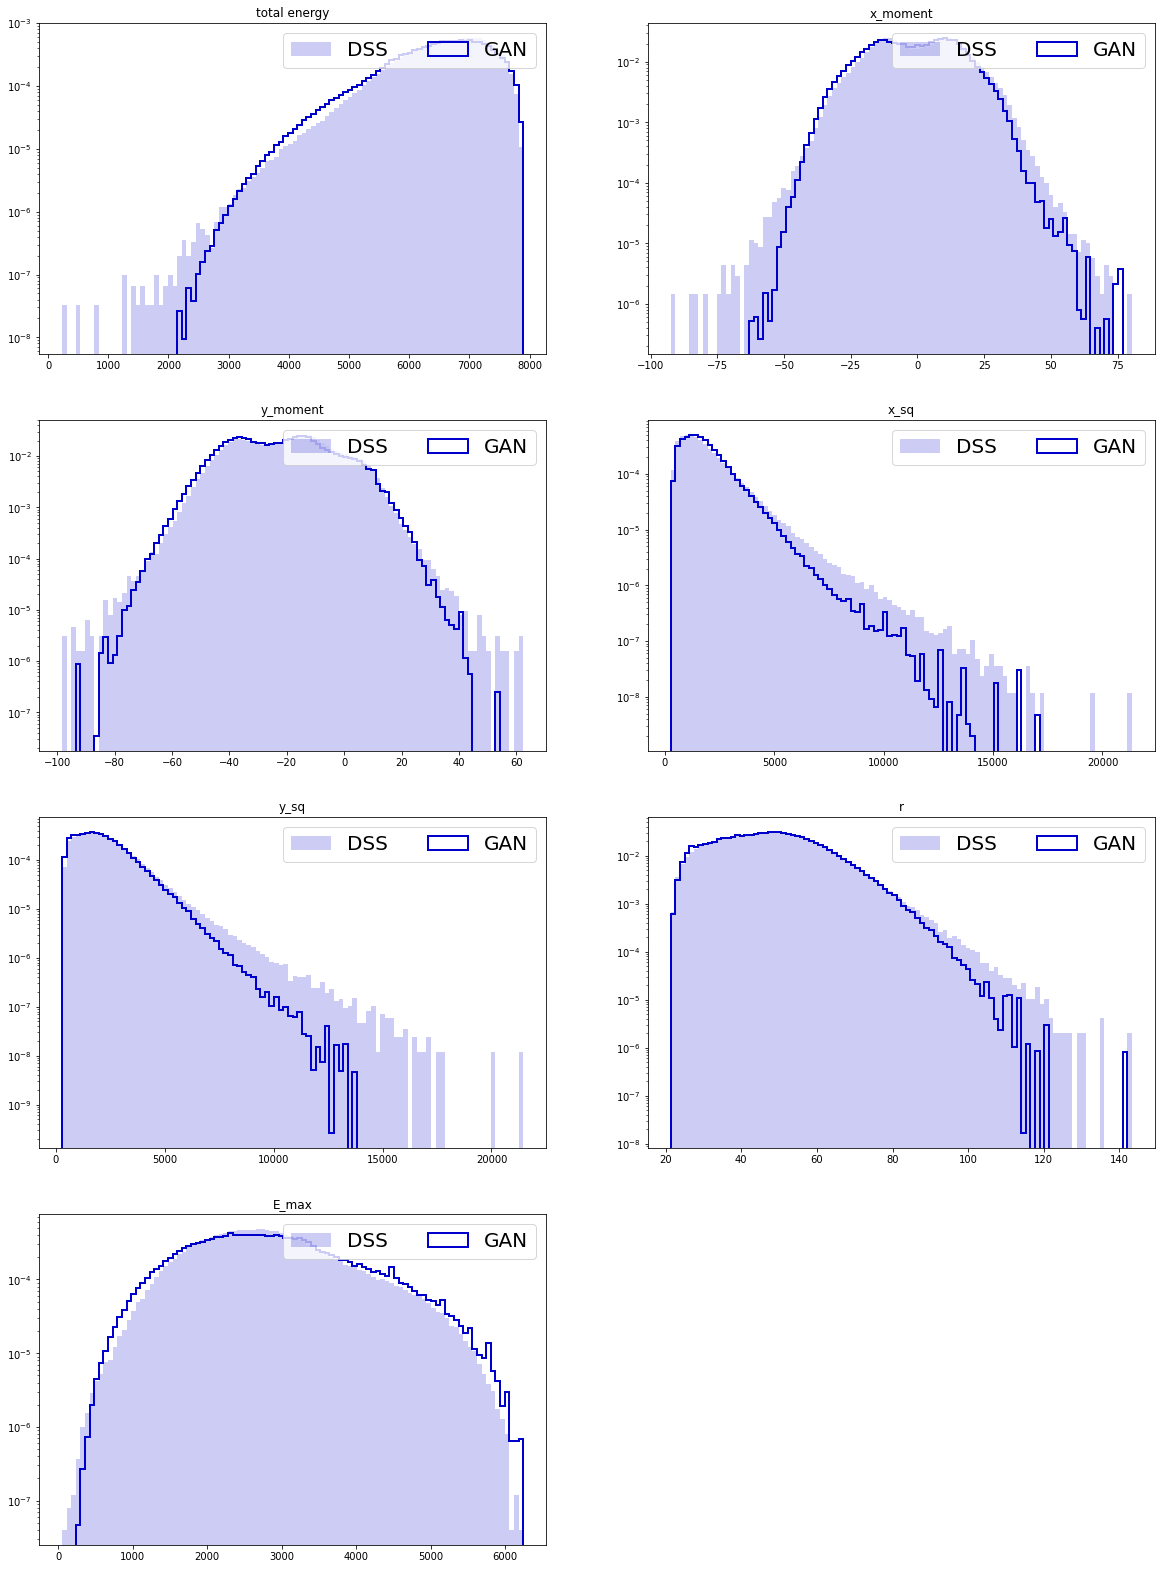

In [46]:
gb_weights_test = reweighter.predict_weights(original)
# validate reweighting rule on the test part comparing 1d projections
KS_data.loc['Gradient Boosted Reweighter'] = draw_distributions(original, target, gb_weights_test)

KS over  total energy  =  0.04004311504383534
KS over  x_moment  =  0.03798980954869258
KS over  y_moment  =  0.04688746981632674
KS over  x_sq  =  0.04049469974413705
KS over  y_sq  =  0.036504568763333634
KS over  r  =  0.010666135341280691
KS over  E_max  =  0.035807472836635656


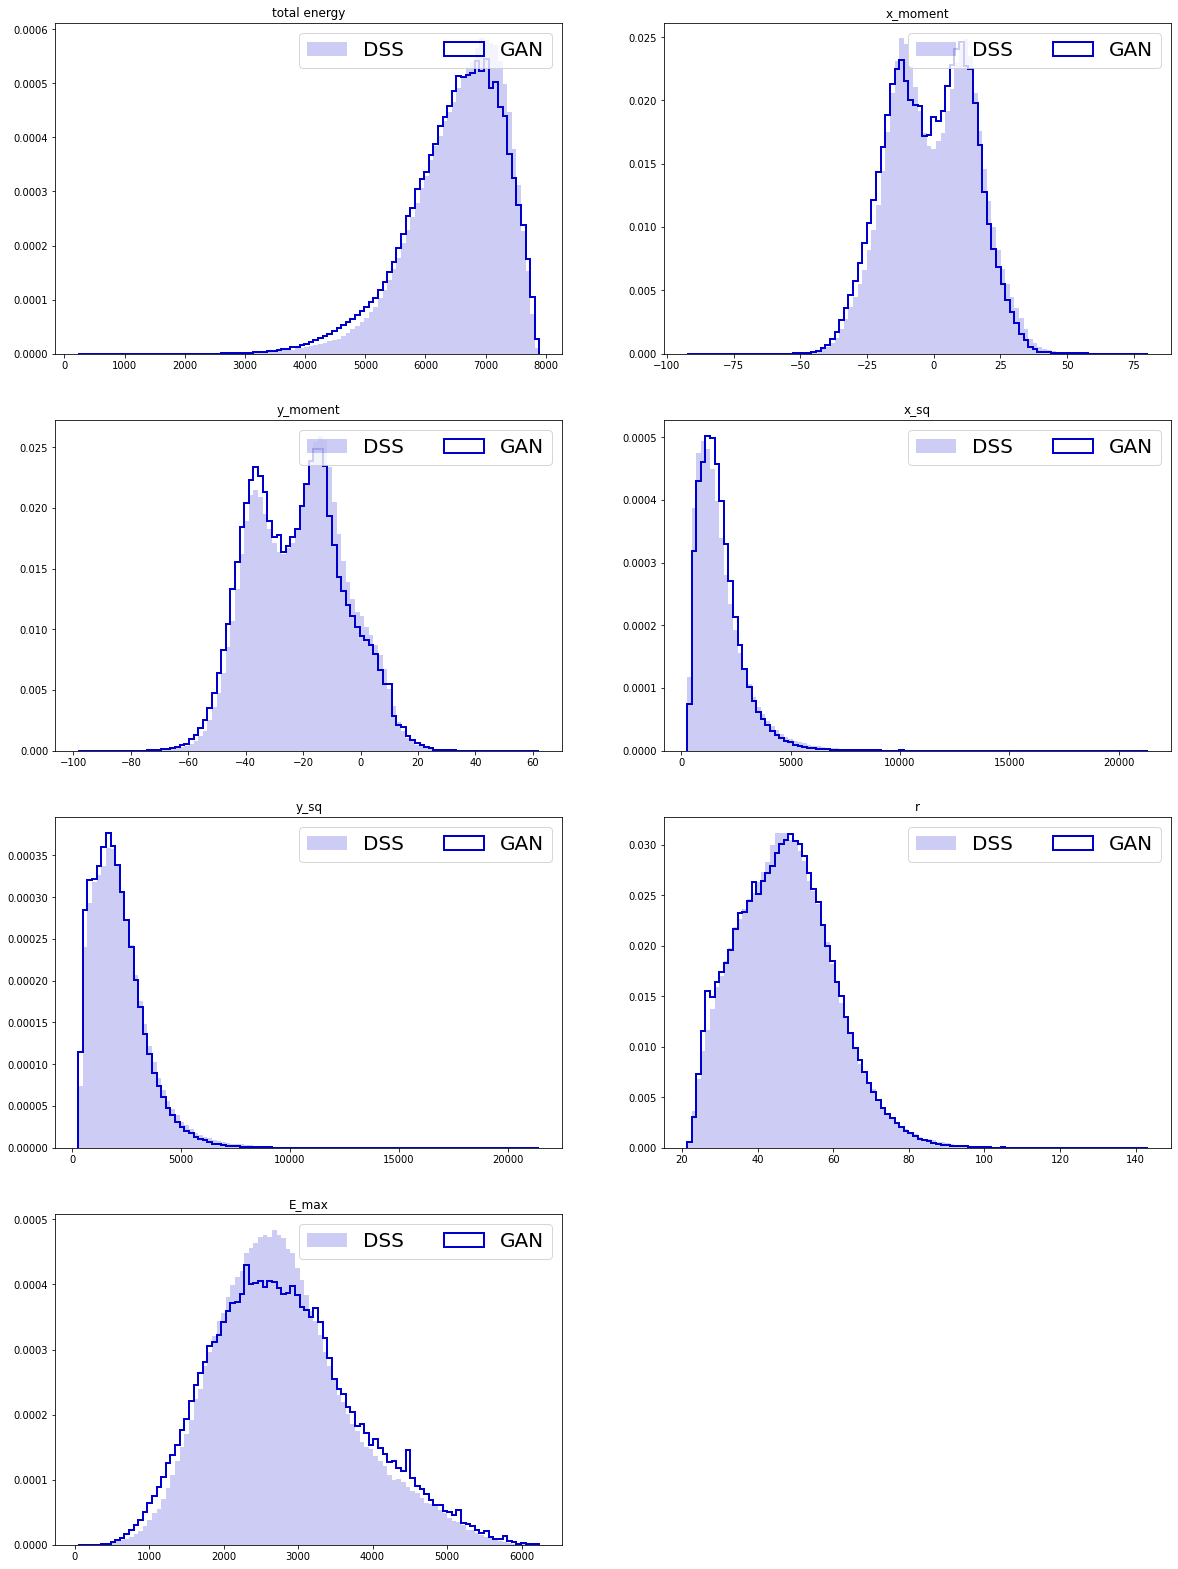

In [47]:
_ = draw_distributions(original, target, gb_weights_test, y_log_scale=False)

In [48]:
weights_data['GB_weights'] = gb_weights_test

In [49]:
#plot_2D_image(np.average(test_generated_image, weights=gb_weights_test,axis=0)[:,:,0],-1)
#plot_2D_image(np.mean(ECAL_centre,axis=0),-2)

### Bins-based reweighting in n dimensions

KS over  total energy  =  0.007570886697705004
KS over  x_moment  =  0.18219539766819015
KS over  y_moment  =  0.04990064417463436
KS over  x_sq  =  0.13528055157521107
KS over  y_sq  =  0.1046178127026719
KS over  r  =  0.04392294106686179
KS over  E_max  =  0.08649646986147685


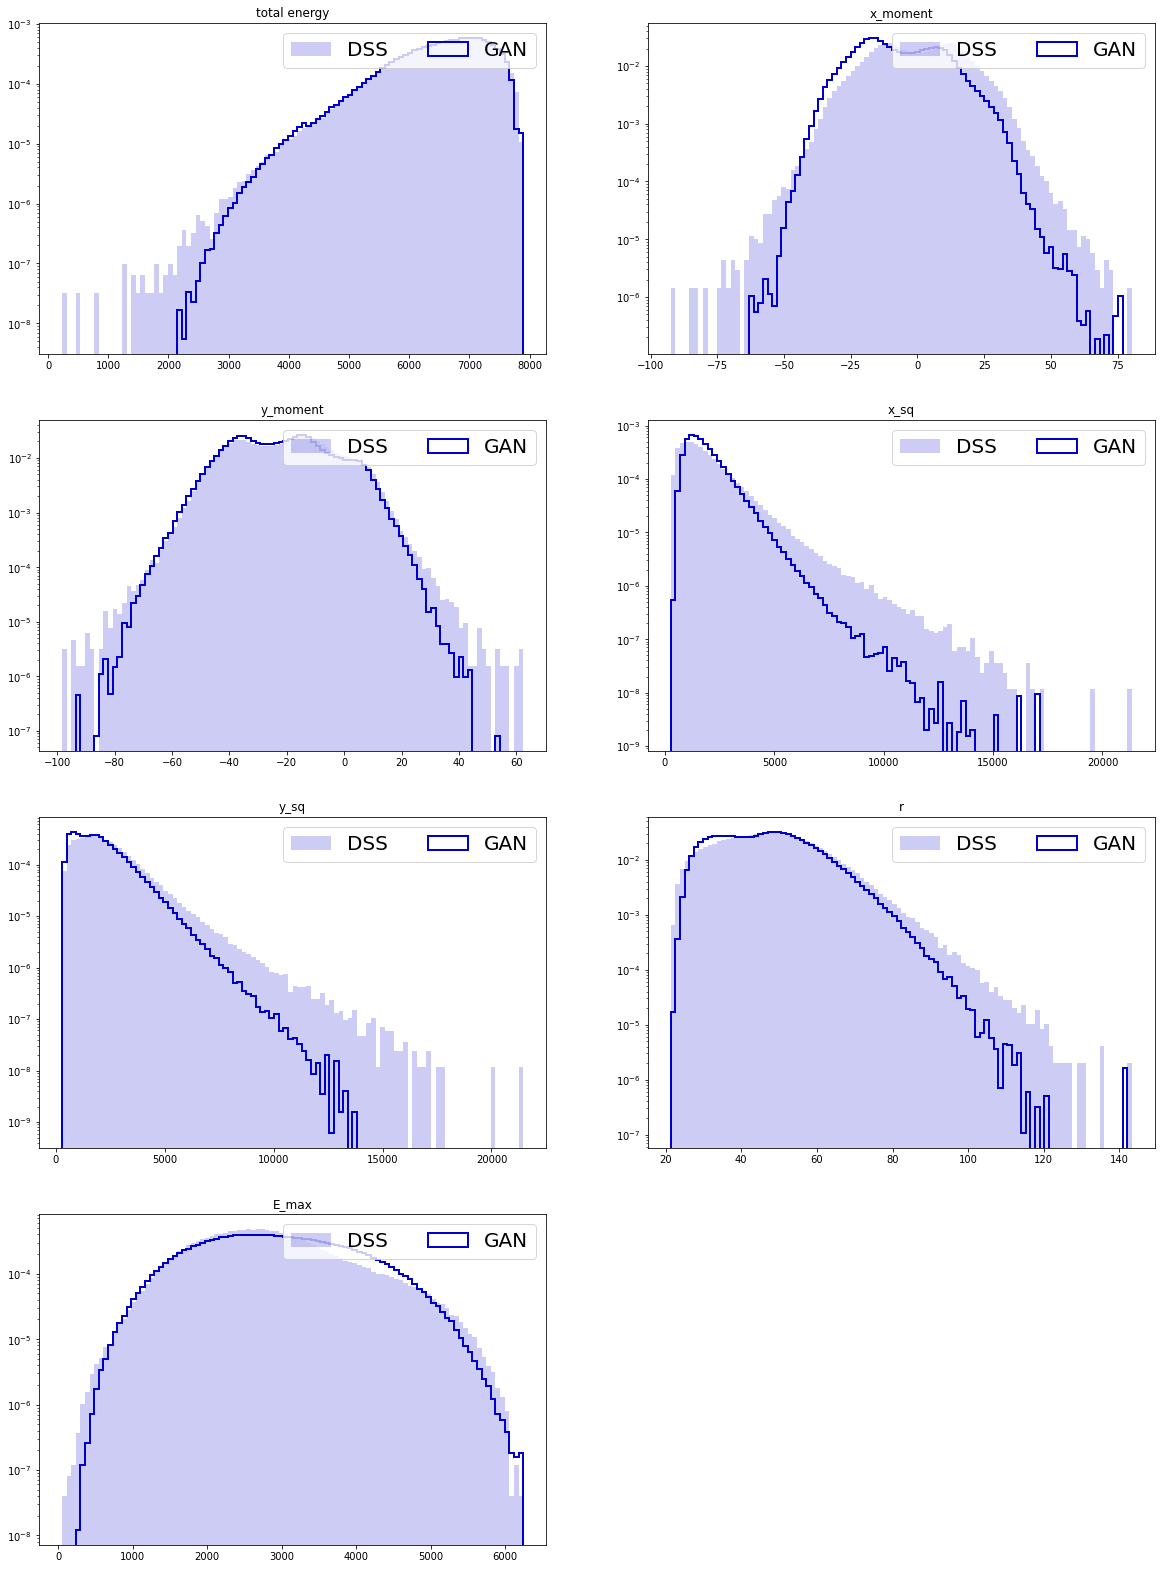

In [50]:
bins_reweighter = reweight.BinsReweighter(n_bins=100, n_neighs=0)
bins_reweighter.fit(original[['total energy']], target[['total energy']])

bins_weights_test = bins_reweighter.predict_weights(original[['total energy']])
# validate reweighting rule on the test part comparing 1d projections
KS_data.loc['Bins-based: total energy'] = draw_distributions(original, target, bins_weights_test)
#plot_2D_image(np.average(test_generated_image, weights=bins_weights_test,axis=0)[:,:,0],-1)
#plot_2D_image(np.mean(ECAL_centre,axis=0),-2)
weights_data['energy_bin_weights'] = bins_weights_test

KS over  total energy  =  0.00829081962679612
KS over  x_moment  =  0.1445488590377223
KS over  y_moment  =  0.053473140774341066
KS over  x_sq  =  0.016269266836046174
KS over  y_sq  =  0.10782662256581216
KS over  r  =  0.06363175052186715
KS over  E_max  =  0.11139712949834457


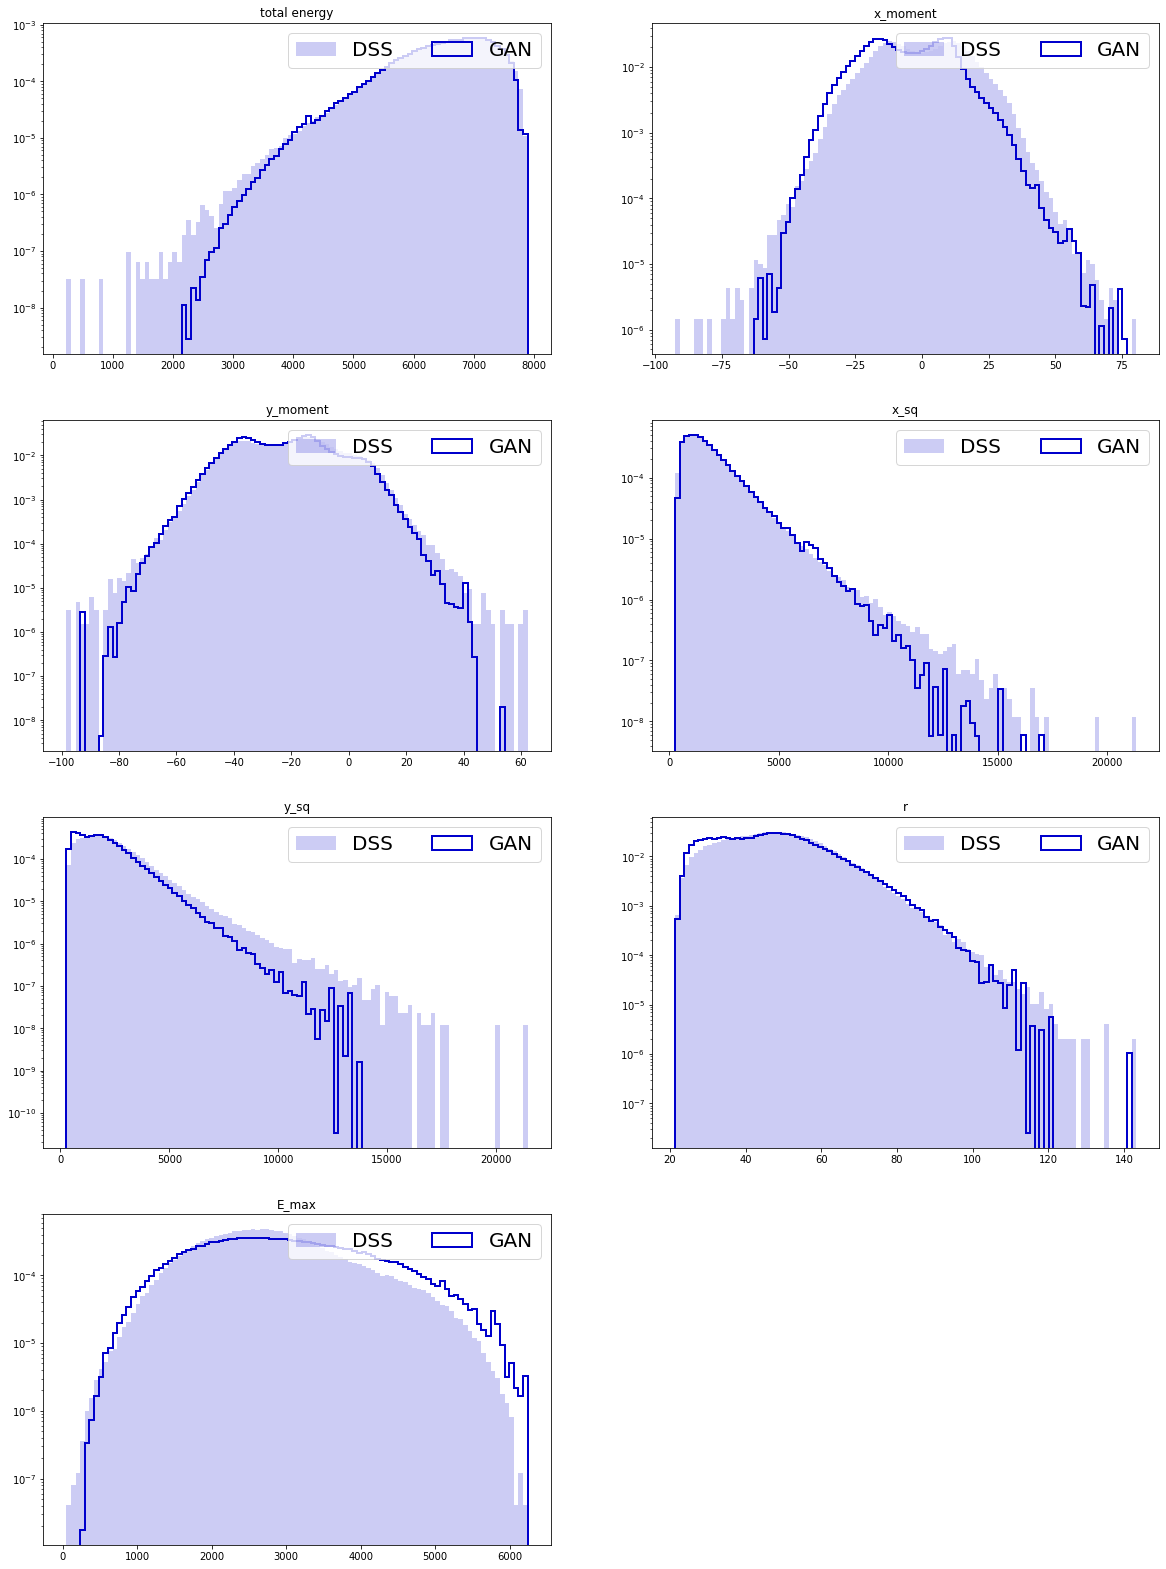

In [51]:
bins_reweighter = reweight.BinsReweighter(n_bins=100, n_neighs=0)
bins_reweighter.fit(original[['total energy','x_sq']], target[['total energy','x_sq']])

bins_weights_test = bins_reweighter.predict_weights(original[['total energy','x_sq']])
KS_data.loc['Bins-based: total energy and x_sq'] = draw_distributions(original, target, bins_weights_test)
#plot_2D_image(np.average(test_generated_image, weights=bins_weights_test,axis=0)[:,:,0],-1)
#plot_2D_image(np.mean(ECAL_centre,axis=0),-2)
weights_data['energy&x_sq_bin_weights'] = bins_weights_test

### Folding reweighter

KFold prediction using folds column
KS over  total energy  =  0.04541358138628648
KS over  x_moment  =  0.04484166640159559
KS over  y_moment  =  0.041923600170722386
KS over  x_sq  =  0.06858265268516367
KS over  y_sq  =  0.06400324106936833
KS over  r  =  0.05535310405473237
KS over  E_max  =  0.0299000515368395


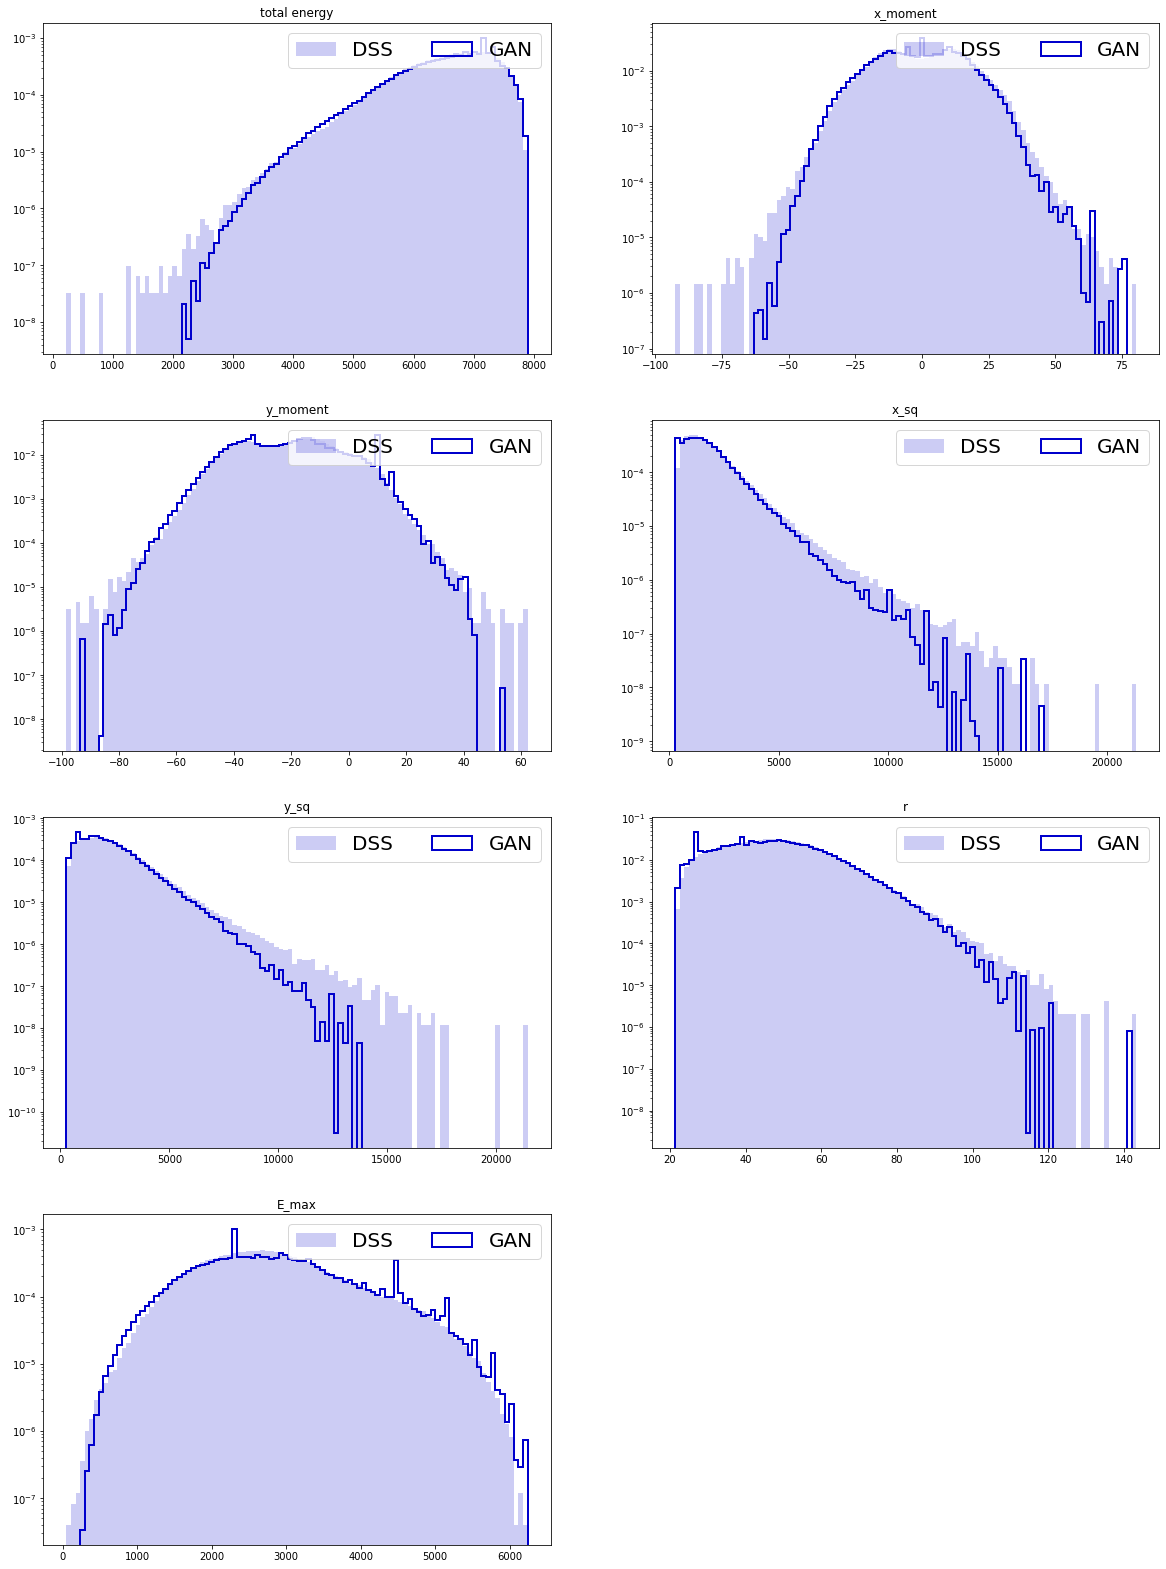

In [52]:
reweighter_base = reweight.GBReweighter(n_estimators=70,
                                        learning_rate=0.1, max_depth=4, min_samples_leaf=1000,
                                        gb_args={'subsample': 0.4})
reweighter = reweight.FoldingReweighter(reweighter_base, n_folds=2)
# it is not needed divide data into train/test parts; rewighter can be train on the whole samples
reweighter.fit(original, target)

# predict method provides unbiased weights prediction for the whole sample
# folding reweighter contains two reweighters, each is trained on one half of samples
# during predictions each reweighter predicts another half of samples not used in training
folding_weights = reweighter.predict_weights(original)

KS_data.loc['Folding reweighter'] = draw_distributions(original, target, folding_weights)
#plot_2D_image(np.average(test_generated_image, weights=folding_weights,axis=0)[:,:,0],-1)
#plot_2D_image(np.mean(ECAL_centre,axis=0),-2)

KS over  total energy  =  0.04541358138628648
KS over  x_moment  =  0.04484166640159559
KS over  y_moment  =  0.041923600170722386
KS over  x_sq  =  0.06858265268516367
KS over  y_sq  =  0.06400324106936833
KS over  r  =  0.05535310405473237
KS over  E_max  =  0.0299000515368395


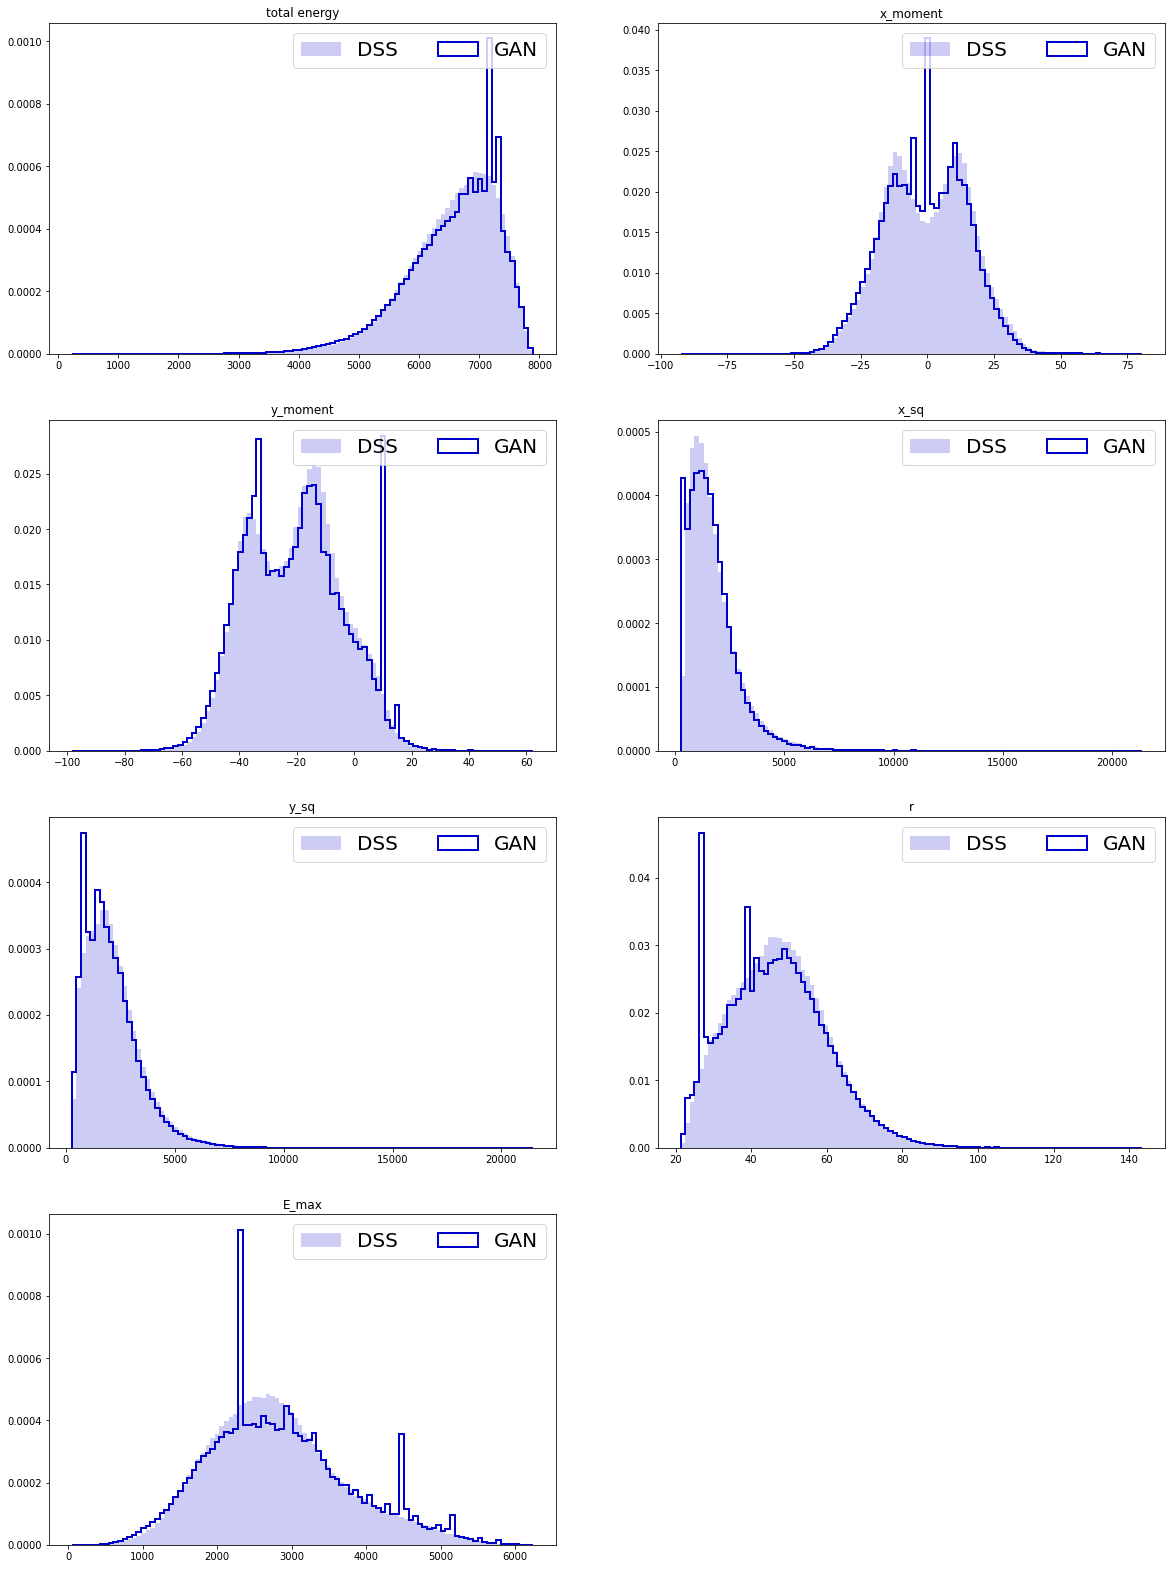

In [53]:
_ = draw_distributions(original, target, folding_weights,y_log_scale=False)

In [54]:
weights_data['folding_weights'] = folding_weights

### Results

original                             0.676775
Gradient Boosted Reweighter          0.248393
Bins-based: total energy             0.609985
Bins-based: total energy and x_sq    0.505438
Folding reweighter                   0.350018
dtype: float64


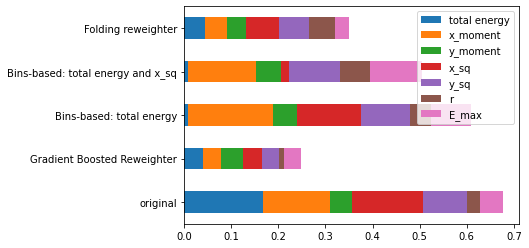

In [55]:
ax = KS_data.plot.barh(stacked=True)
print(KS_data.apply(lambda x:x.sum(),axis =1))

# Save model

In [116]:
from datetime import datetime
import pytz

tz = pytz.timezone('Asia/Shanghai') #GMT +8
t = datetime.fromtimestamp(int(time.time()),
    pytz.timezone('Asia/Shanghai')).strftime('%Y-%m-%d_%H:%M:%S')
print(t)
#save_type = le.inverse_transform(range(nb_classes))
save_type = list(particle_label.keys())[0]
print("Type :",save_type)
g_model.save_weights('/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/Models/{}LOGANgenerator_{}.hdf5'.format(t,save_type,
                                                                                                                      overwrite=True))
d_model.save_weights('/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/Models/{}LOGANdiscriminator_{}.hdf5'.format(t,save_type,
                                                                                                                      overwrite=True))
saved_model_path = '/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/saved_model'
tf.saved_model.save(g_model, saved_model_path)
#tf.saved_model.save(d_model, saved_model_path)

2021-07-21_20:58:09
Type : PN_ECAL_4e5

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: /content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/saved_model/assets


In [67]:
print(tf.__version__)
print(np.__version__)
print(pd.__version__)

2.5.0
1.19.5
1.1.5


# Correlation

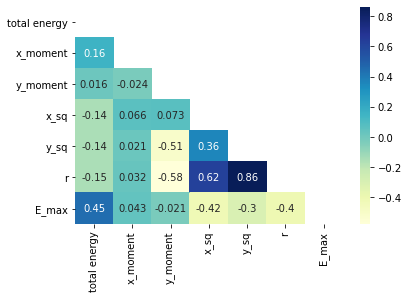

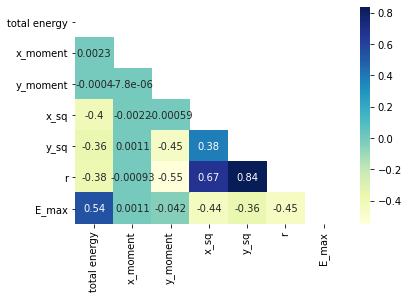

In [ ]:
import seaborn as sn

corrMatrix = original.corr()
mask_matrix = np.triu(corrMatrix)

sn.heatmap(corrMatrix, annot=True, cmap="YlGnBu", mask=mask_matrix)
plt.show()

corrMatrix = target.corr()
sn.heatmap(corrMatrix, annot=True, cmap="YlGnBu", mask=mask_matrix)
plt.show()

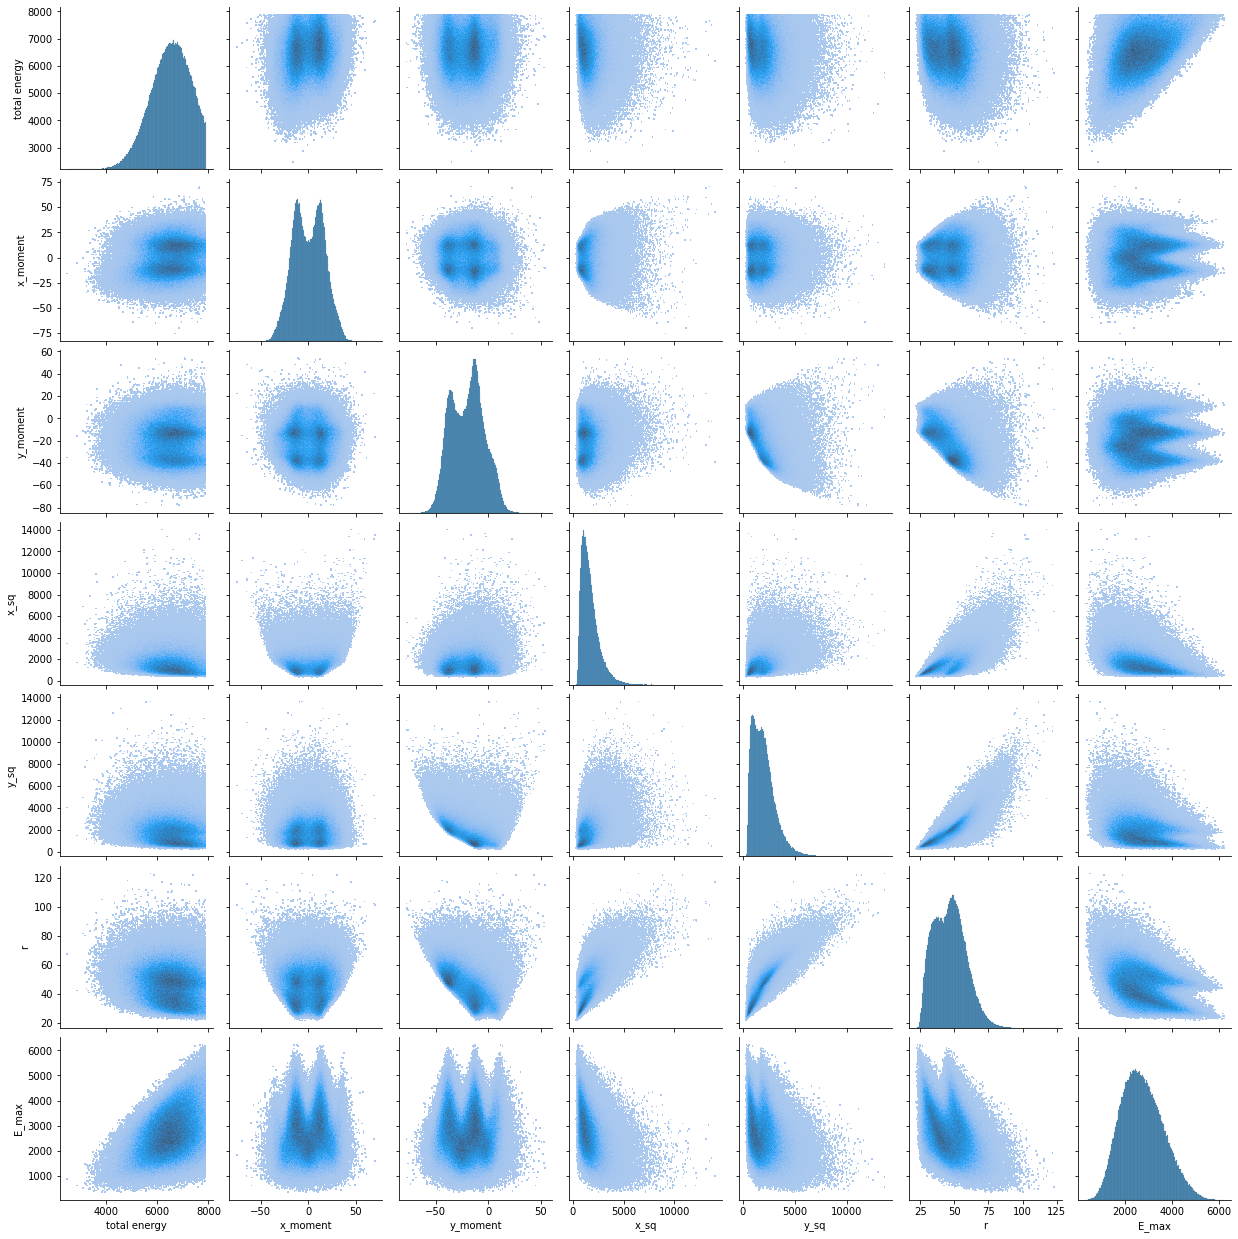

In [ ]:
sn.pairplot(original,kind="hist")

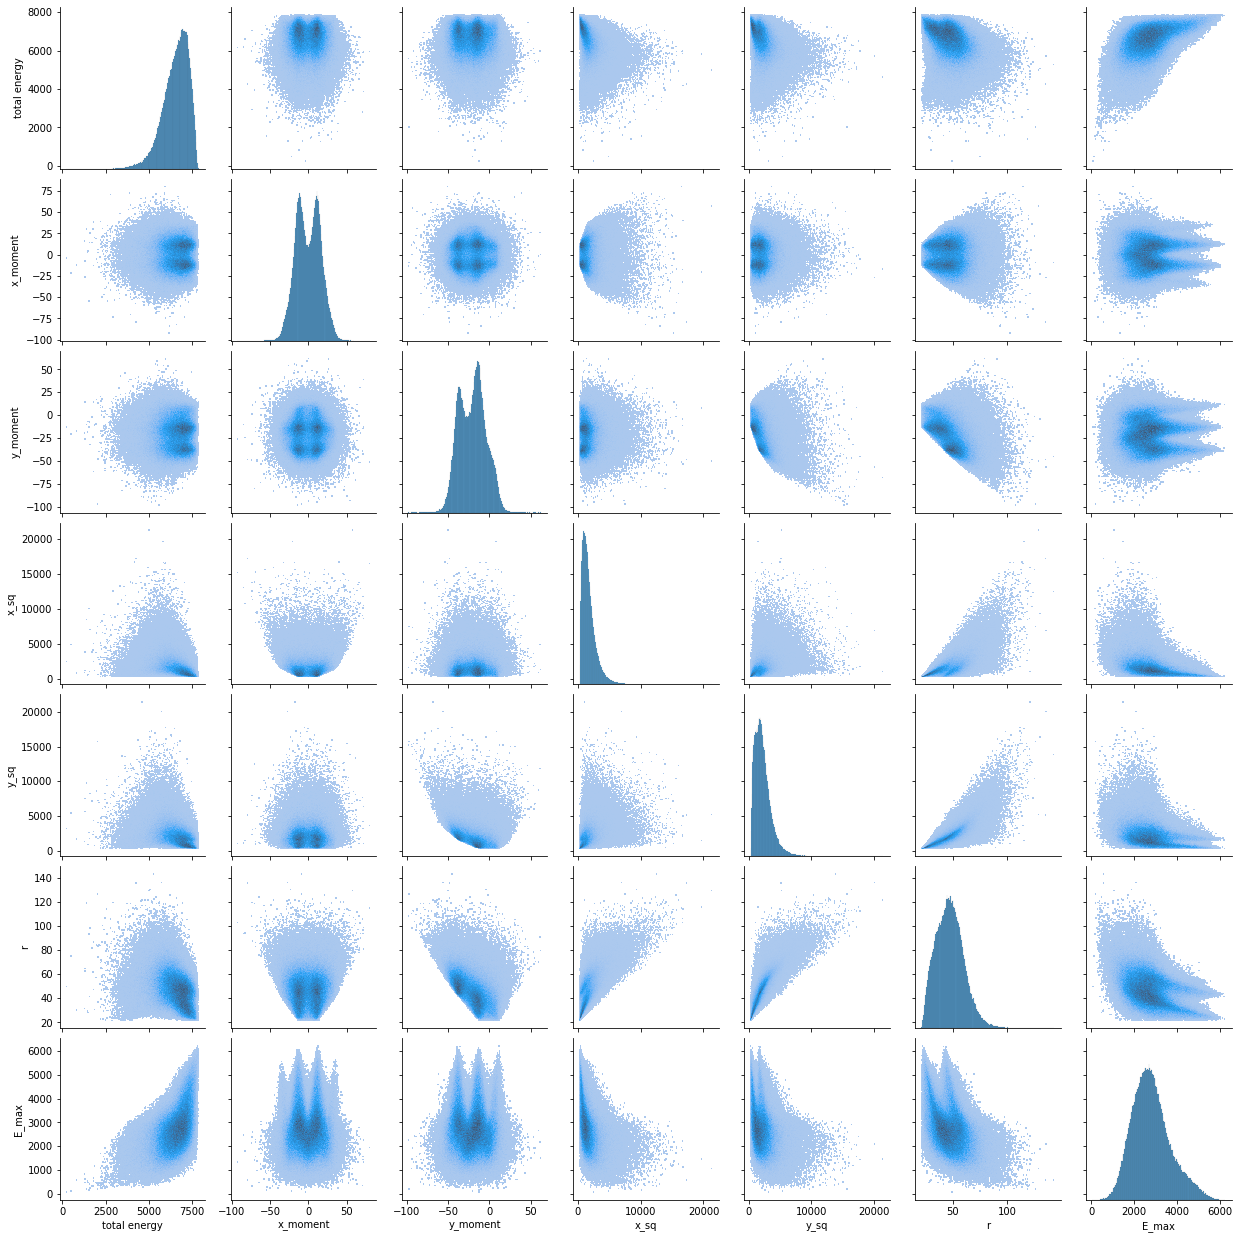

In [ ]:
sn.pairplot(target,kind="hist")

In [ ]:
original['type'] = 'GAN'
target['type'] = 'DSS'
combined_df = pd.concat([original,target])

In [ ]:
print(len(combined_df))

859698


In [ ]:
#sn.pairplot(combined_df,kind="hist",hue='type')

# Write variables

In [ ]:
def write_hdf5(filenames, **variables):
    with h5py.File(filenames, 'w') as hf:
        for key, item in variables.items():
            hf.create_dataset(key, data=item)

In [ ]:
from datetime import datetime
import pytz

tz = pytz.timezone('Asia/Shanghai') #GMT +8
t = datetime.fromtimestamp(int(time.time()),
    pytz.timezone('Asia/Shanghai')).strftime('%Y-%m-%d_%H:%M:%S')
print(t)
variable_path = '/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/GeneratedVariables/'
variable_file_name  = variable_path + t + '_' + list(particle_label.keys())[0] + 'generated_variables.hdf5'
print(variable_file_name)

2021-07-16_01:50:31
/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/GeneratedVariables/2021-07-16_01:50:31_PN_ECAL_4e5generated_variables.hdf5


In [ ]:
write_hdf5(variable_file_name, **generated_variables)

# Save ROOT file

In [57]:
!pip install uproot3
!pip install uproot
!pip install awkward
import uproot3
import uproot
from datetime import datetime
import pytz
import awkward0
import awkward as ak
tz = pytz.timezone('Asia/Shanghai') #GMT +8
t = datetime.fromtimestamp(int(time.time()),
    pytz.timezone('Asia/Shanghai')).strftime('%Y-%m-%d-%H-%M-%S')
print(t)
root_path = '/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/Generated_ROOT/'
#root_path = '/content/'
output_root_file  = root_path + t + '_' + list(particle_label.keys())[0] + '.root'
print(output_root_file)

     |████████████████████████████████| 117 kB 7.7 MB/s 
     |████████████████████████████████| 87 kB 7.9 MB/s 
     |████████████████████████████████| 245 kB 7.6 MB/s 
     |████████████████████████████████| 13.6 MB 8.4 MB/s 
2021-07-20-21-10-46
/content/drive/Shareddrives/desmond.z.he1998.HK(CRN.NGO)/Generated_ROOT/2021-07-20-21-10-46_GMM_Target_8e5.root


In [58]:
print(np.array(original['r']).shape)
print(test_generated_image.shape)
#image_in_root = awkward0.fromiter(test_generated_image.reshape((len(test_generated_image),-1)))
image_in_root = test_generated_image.reshape((len(test_generated_image),-1)).astype(np.dtype(">f4"))
#image_in_root = ak.to_awkward0(ak.from_numpy(image_in_root))
print(image_in_root.shape)
print(image_in_root.dtype)
print()

(1000000,)
(1000000, 20, 20, 1)
(1000000, 400)
>f4



In [59]:
out_file = uproot3.recreate(output_root_file
                            ,compression=None
                            #Out of memory when tried with default compression
                            )
out_file['dp'] = uproot3.newtree({
    'image' : uproot3.newbranch(np.dtype(">f4"),shape=image_in_root.shape),
    'total_energy': np.float32, 
    'x_moment': np.float32, 
    'y_moment': np.float32, 
    'x_sq': np.float32, 
    'y_sq': np.float32, 
    'r': np.float32, 
    'E_max': np.float32,
    'weight': np.float32
})

dict_to_write = {
    'image' : image_in_root,
    #"n" : image_in_root.counts,
    ############################################
    'total_energy': np.array(original['total energy'], dtype=np.float32), 
    'x_moment': np.array(original['x_moment'], dtype=np.float32), 
    'y_moment': np.array(original['y_moment'], dtype=np.float32), 
    'x_sq': np.array(original['x_sq'], dtype=np.float32), 
    'y_sq': np.array(original['y_sq'], dtype=np.float32), 
    'r': np.array(original['r'], dtype=np.float32), 
    'E_max': np.array(original['E_max'], dtype=np.float32),
    ############################################
    #'weight': np.array(weights_data['GB_weights']),
    'weight': np.array(weights_data['GB_weights'], dtype=np.float32),
    }
for key in dict_to_write.keys():
    out_file["dp"][key].newbasket(dict_to_write[key])


out_file.close()

In [60]:
variables = [
    'image',
    'total_energy', 
    'x_moment', 
    'y_moment', 
    'x_sq', 
    'y_sq', 
    'r', 
    'E_max',
    #'weight'
            ]
tree_name = 'dp'
events = uproot.open(output_root_file+':'+tree_name) 
data = events.arrays(variables,library="np")

In [61]:
print(image_in_root[1][:15].dtype)
print(image_in_root[2][:15].dtype)
print(image_in_root[3][:15].dtype)
print(image_in_root[4][:15].dtype)
print(image_in_root[5][:15].dtype)
print(image_in_root[6][:15].dtype)
print(image_in_root[7][:15].dtype)

>f4
>f4
>f4
>f4
>f4
>f4
>f4


395078
1855.3921 0.0
float32


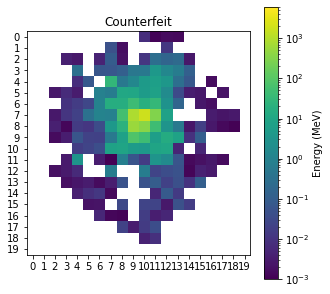

In [65]:
idx = np.random.randint(len(data['image']))
print(idx)
print(np.max(data['image'][idx]),np.min(data['image'][idx]))
print(data['image'][idx][:15].dtype)
plot_2D_image(data['image'][idx].reshape(20,20),-1)

# GIF

In [ ]:
def create_gif(image_list, gif_name):  
  
    frames = []  
    for image_name in image_list:  
        frames.append(imageio.imread(image_name))  
    # Save them as frames into a gif   
    imageio.mimsave(gif_name, frames, 'GIF', duration = 0.25)  
  
    return 
def find_all_png():

    png_filenames = glob.glob('2D_image*0[0-2]*.png')
    png_filenames = sorted(png_filenames)
    buf=[]
    for png_file in png_filenames:
        buf.append(png_file)
    return buf

buff = find_all_png()
create_gif(buff,'2D_gif.gif' )